Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 21

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=21
num_BackTrack_Days=2

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=12 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
#
drop_n_dataset_days=520
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
250                                           NaN                    Togo   
251                                           NaN                   Tonga   
252                                           NaN     Trinidad and Tobago   
253                                           NaN                 Tunisia   
254                                           NaN                  Turkey   
255                                           NaN           United States   
256                                           NaN                  Uganda   
257                                           NaN                 Ukraine   
258                                           NaN    United Arab Emirates   
259                                      Anguilla          United Kingdom   
260                                       Bermuda          United Kingdom   
261                        British Virgin Islands          United Kingdom   
262                                Cayman Islands          United Kingdom   
263                               Channel Islands          United Kingdom   
264                   Falkland Islands (Malvinas)          United Kingdom   
265                                     Gibraltar          United Kingdom   
266                                   Isle of Man          United Kingdom   
267                                    Montserrat          United Kingdom   
268  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
269                      Turks and Caicos Islands          United Kingdom   
270                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
256                                           NaN                    Togo   
257                                           NaN                   Tonga   
258                                           NaN     Trinidad and Tobago   
259                                           NaN                 Tunisia   
260                                           NaN                  Turkey   
261                                           NaN           United States   
262                                           NaN                  Uganda   
263                                           NaN                 Ukraine   
264                                           NaN    United Arab Emirates   
265                                      Anguilla          United Kingdom   
266                                       Bermuda          United Kingdom   
267                        British Virgin Islands          United Kingdom   
268                                Cayman Islands          United Kingdom   
269                               Channel Islands          United Kingdom   
270                   Falkland Islands (Malvinas)          United Kingdom   
271                                     Gibraltar          United Kingdom   
272                                   Isle of Man          United Kingdom   
273                                    Montserrat          United Kingdom   
274  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
275                      Turks and Caicos Islands          United Kingdom   
276                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  1/7/22  1/8/22  1/9/22  1/10/22  \
185        0        0        0        0  ...     485     487     487      488   
186        0        0        0        0  ...       0       0       0        0   
187        0        0        0        0  ...     881     885     886      888   
188        0        0        0        0  ...     240     240     240      240   
189        0        0        0        0  ...  300101  300303  300334   300334   
190        0        0        0        0  ...       0       0       0        0   
191        0        0        0        0  ...   10350   10356   10363    10380   
192        0        0        0        0  ...      42      42      42       42   
193        0        0        0        0  ...    2070    2070    2074     2074   
194        0        0        0        0  ...    2433    2434    2442     2448   

     1/11/22  1/12/22  1/13/22  1/14/22   Population                 region  
185      492      496      496      501       441,543             Malta_nan  
186        0        0        0        0           NaN  Marshall Islands_nan  
187      891      893      895      900     4,649,658        Mauritania_nan  
188      240      240      240      240     1,273,985         Mauritius_nan  
189   300574   300764   300912   300912   128,640,794            Mexico_nan  
190        0        0        0        0           NaN        Micronesia_nan  
191    10397    10406    10416    10427     4,035,942           Moldova_nan  
192       44       44       44       44        39,183            Monaco_nan  
193     2076     2079     2079     2082     3,278,290          Mongolia_nan  
194     2453     2457     2460     2465       622 500        Montenegro_nan  

[10 rows x 730 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN         Monaco  43.733300    7.41670   
176                               NaN       Mongolia  46.862500  103.84670   
177                               NaN     Montenegro  42.708678   19.37439   
178                               NaN        Morocco  31.791700   -7.09260   
179                               NaN     Mozambique -18.665700   35.52960   
180                               NaN        Namibia -22.957600   18.49040   
181                               NaN          Nepal  28.166700   84.25000   
182                             Aruba    Netherlands  12.521100  -69.96830   
183  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   
184                           Curacao    Netherlands  12.169600  -68.99000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  1/7/22  \
175        0        0        0        0        0        0  ...       0   
176        0        0        0        0        0        0  ...       0   
177        0        0        0        0        0        0  ...       0   
178        0        0        0        0        0        0  ...       0   
179        0        0        0        0        0        0  ...       0   
180        0        0        0        0        0        0  ...       0   
181        0        0        0        0        0        0  ...       0   
182        0        0        0        0        0        0  ...       0   
183        0        0        0        0        0        0  ...       0   
184        0        0        0        0        0        0  ...       0   

     1/8/22  1/9/22  1/10/22  1/11/22  1/12/22  1/13/22  1/14/22  \
175       0       0        0        0        0        0        0   
176       0       0        0        0        0        0        0   
177       0       0        0        0        0        0        0   
178       0       0        0        0        0        0        0   
179       0       0        0        0        0        0        0   
180       0       0        0        0        0        0        0   
181       0       0        0        0        0        0        0   
182       0       0        0        0        0        0        0   
183       0       0        0        0        0        0        0   
184       0       0        0        0        0        0        0   

      Population                                         region  
175        39,183                                    Monaco_nan  
176     3,278,290                                  Mongolia_nan  
177       622 500                                Montenegro_nan  
178    36,817,128                                   Morocco_nan  
179    31,542,919                                Mozambique_nan  
180     2,540,905                                   Namibia_nan  
181    29,300,000                                     Nepal_nan  
182       116,600                             Netherlands_Aruba  
183        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  
184       158,665                           Netherlands_Curacao  

[10 rows x 730 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...   1/7/22   1/8/22   1/9/22  \
185        0        0        0        0  ...    59061    59823    60386   
186        0        0        0        0  ...        7        7        7   
187        0        0        0        0  ...    47036    48105    49006   
188        0        0        0        0  ...    23886    24051    24051   
189        0        0        0        0  ...  4083118  4113789  4125388   
190        0        0        0        0  ...        1        1        1   
191        0        0        0        0  ...   379572   379901   380290   
192        0        0        0        0  ...     5593     5593     5593   
193        0        0        0        0  ...   393470   393470   395129   
194        0        0        0        0  ...   185606   187825   190279   

     1/10/22  1/11/22  1/12/22  1/13/22  1/14/22   Population   \
185    60823    61255    61928    62390    62906       441,543   
186        7        7        7        7        7           NaN   
187    49673    50702    51795    52772    53643     4,649,658   
188    24264    24264    24425    24425    24425     1,273,985   
189  4125388  4170066  4214253  4257776  4257776   128,640,794   
190        1        1        1        1        1           NaN   
191   380985   382124   383544   385047   386905     4,035,942   
192     6087     6165     6266     6362     6485        39,183   
193   396337   398155   400434   400452   402462     3,278,290   
194   192171   194695   196640   198857   200535       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 730 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                          Portugal  39.399900   -8.224500   
221            NaN                             Qatar  25.354800   51.183900   
222            NaN                           Romania  45.943200   24.966800   
223            NaN                            Russia  61.524010  105.318756   
224            NaN                            Rwanda  -1.940300   29.873900   
225            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
226            NaN                       Saint Lucia  13.909400  -60.978900   
227            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
228            NaN                             Samoa -13.759000 -172.104600   
229            NaN                        San Marino  43.942400   12.457800   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...    1/7/22  \
220        0        0        0        0        0        0  ...   1577784   
221        0        0        0        0        0        0  ...    263475   
222        0        0        0        0        0        0  ...   1833789   
223        0        0        0        0        0        0  ...  10437471   
224        0        0        0        0        0        0  ...    119421   
225        0        0        0        0        0        0  ...      3904   
226        0        0        0        0        0        0  ...     14414   
227        0        0        0        0        0        0  ...      6247   
228        0        0        0        0        0        0  ...         3   
229        0        0        0        0        0        0  ...      9095   

       1/8/22    1/9/22   1/10/22   1/11/22   1/12/22   1/13/22   1/14/22  \
220   1613427   1639846   1660058   1693398   1734343   1774477   1814567   
221    266962    270651    274529    278698    282904    287091    291214   
222   1839825   1844537   1848641   1857502   1866102   1875887   1885771   
223  10453895  10470006  10485705  10503101  10520898  10541870  10565484   
224    120374    120984    121742    122403    123166    123886    124419   
225      4056      4145      4216      4339      4484      4645      4645   
226     14654     14874     15101     15372     15937     16505     16969   
227      6247      6247      6247      6562      6562      6575      6581   
228         3         3         3         3         3         3         3   
229      9095      9095      9518      9518     10009     10189     10350   

      Population                                 region  
220    10,290,000                          Portugal_nan  
221     2,870,256                             Qatar_nan  
222    19,530,000                           Romania_nan  
223   144,500,000                            Russia_nan  
224    12,952,218                            Rwanda_nan  
225        53,673             Saint Kitts and Nevis_nan  
226       184,106                       Saint Lucia_nan  
227       110,940  Saint Vincent and the Grenadines_nan  
228           NaN                             Samoa_nan  
229        33,916                        San Marino_nan  

[10 rows x 730 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

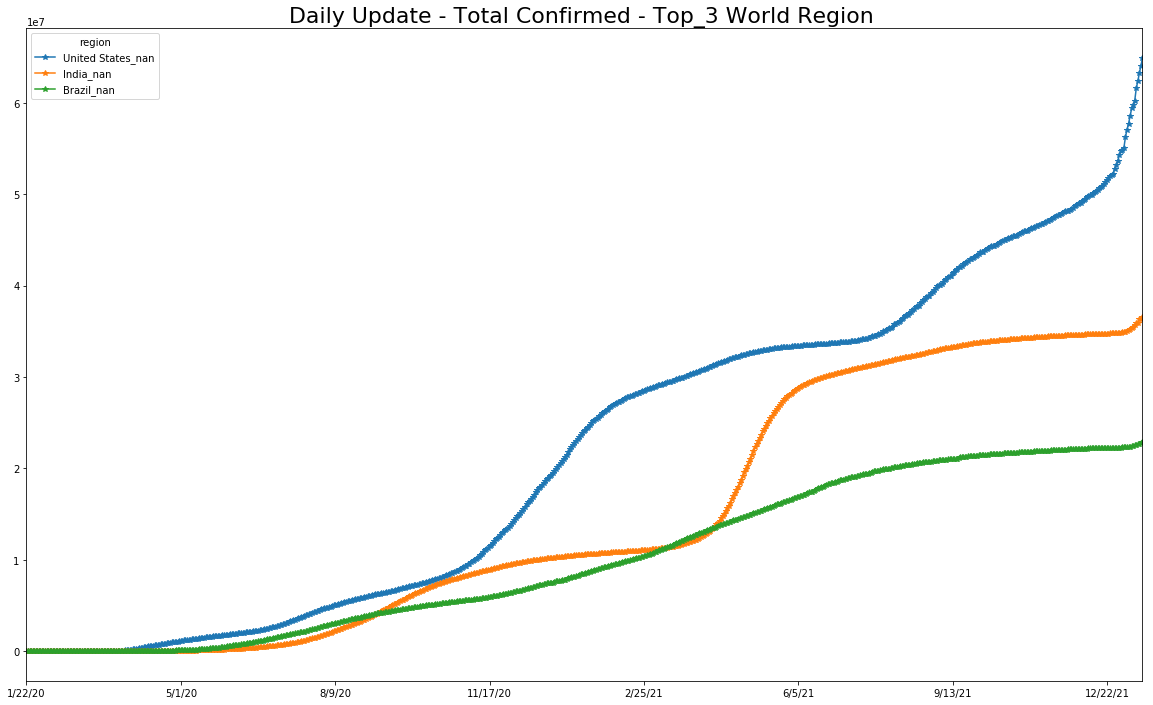

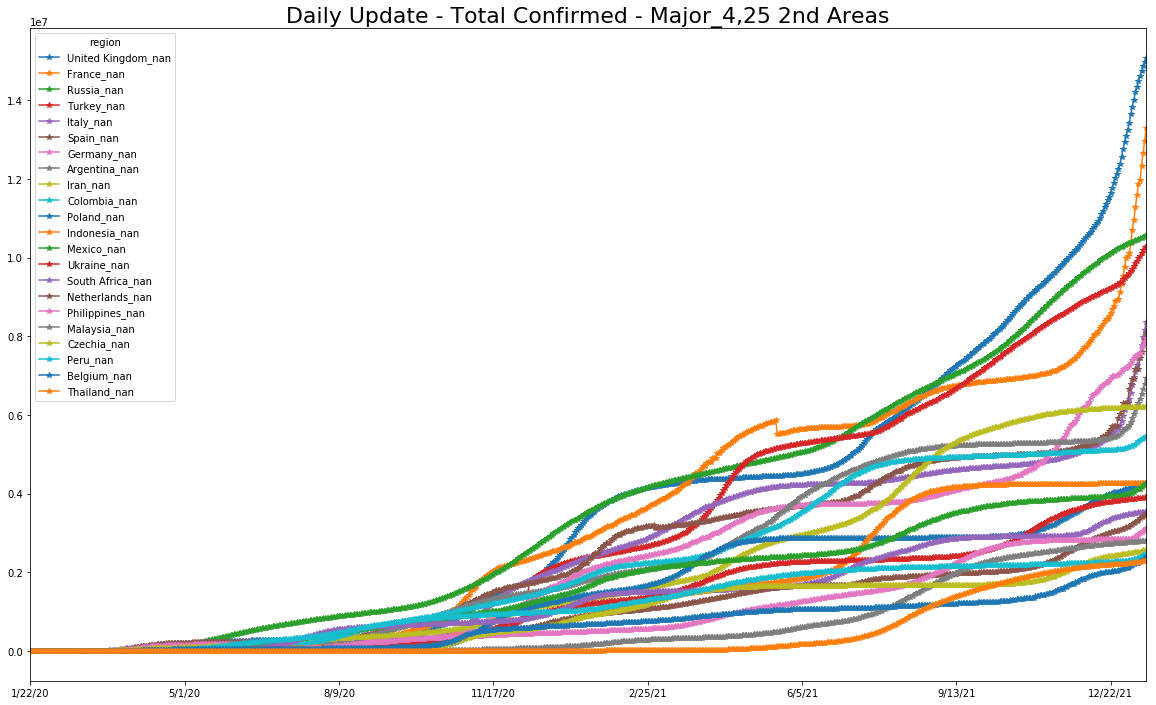

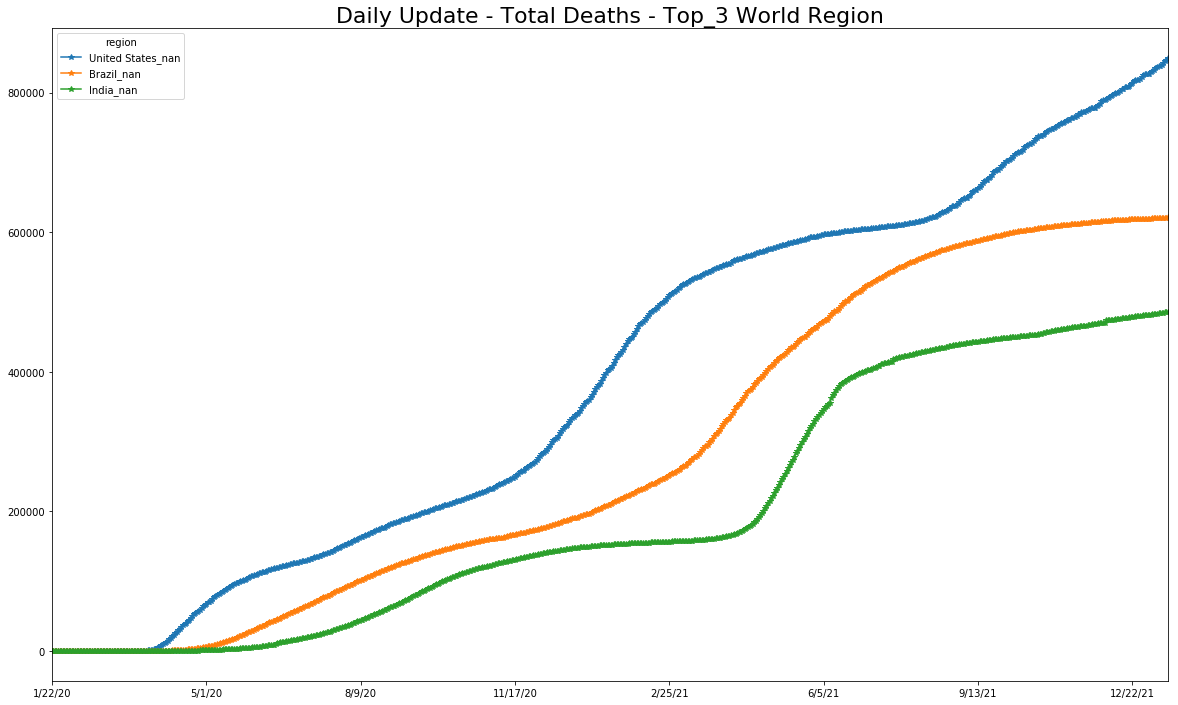

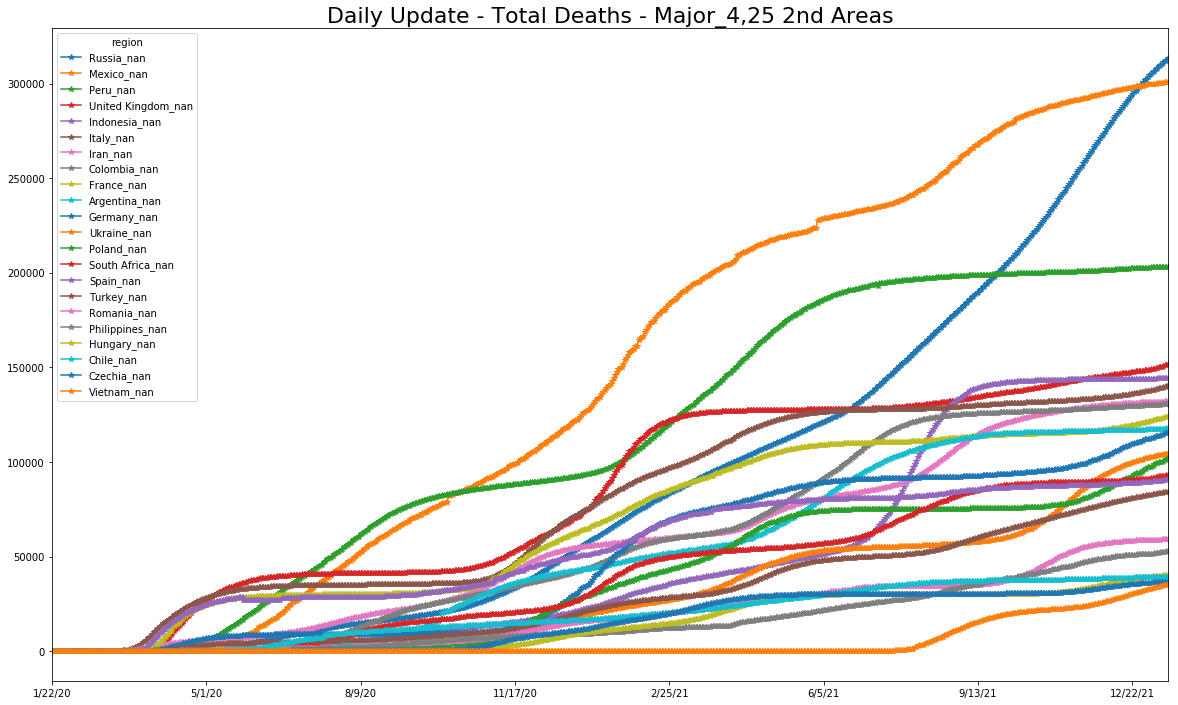

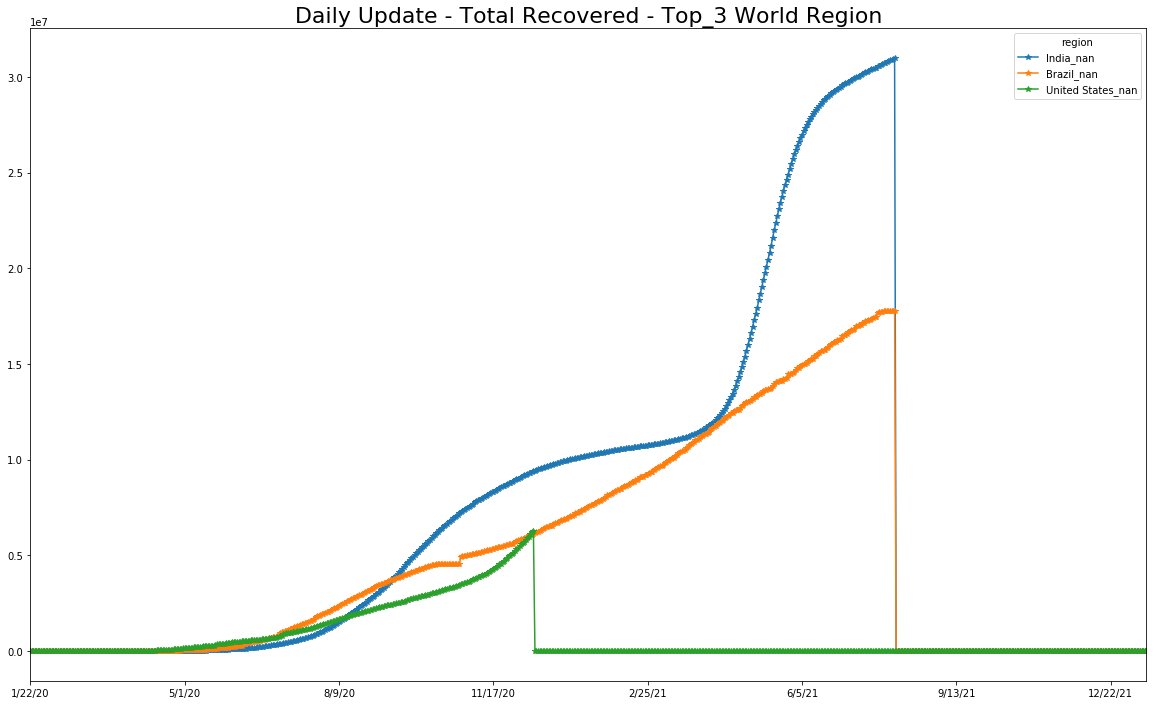

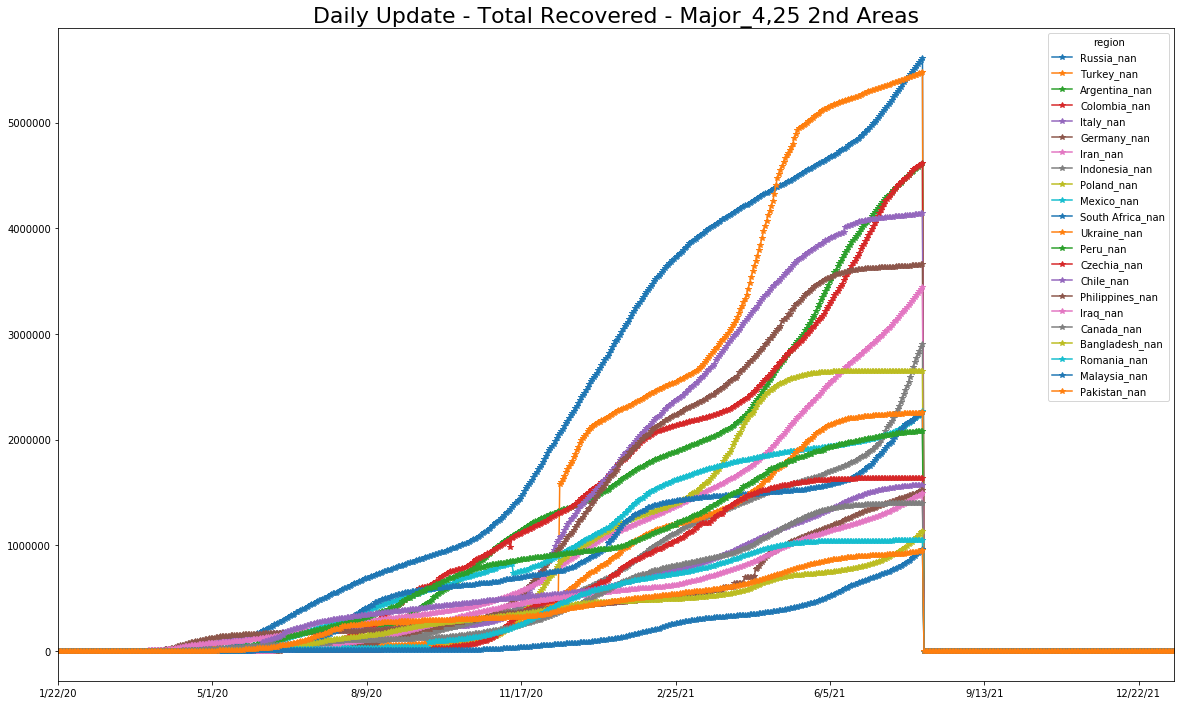

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/01/15


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
6/25/21           111592       132506       137772        13882       38371   
6/26/21           113124       132509       138113        13882       38528   
6/27/21           114220       132512       138465        13882       38556   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
6/25/21                     1263        4374587       224635   
6/26/21                     1263        4393142       224728   
6/27/21                     1263        4405247       224797   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
6/25/21                                     124                       5725   
6/26/21                                     124                       5756   
6/27/21                                     124                       5778   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
6/25/21  ...           33693871       363580          108184            4   
6/26/21  ...           33702743       364859          108730            4   
6/27/21  ...           33707125       365866          109223            4   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
6/25/21         266952        14537                  313520       6905   
6/26/21         268349        15325                  313520       6906   
6/27/21         269635        15740                  313721       6908   

region   Zambia_nan  Zimbabwe_nan  
6/25/21      143215         45217  
6/26/21      146031         46018  
6/27/21      148568         46442  

[3 rows x 280 columns]

In [25]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
1/11/22           158471       222664       223196        28542       91148   
1/12/22           158511       224569       223806        28899       91907   
1/13/22           158602       226598       224383        28899       92581   
1/14/22           158639       228777       224979        29888       93302   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
1/11/22                     5058        6533635       346224   
1/12/22                     5214        6664717       346811   
1/13/22                     5214        6793119       346811   
1/14/22                     5246        6932972       347084   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
1/11/22                                   15834                     536025   
1/12/22                                   17378                     628289   
1/13/22                                   19908                     690758   
1/14/22                                   21174                     738891   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
1/11/22  ...           62385927       463357          201155            7   
1/12/22  ...           63285605       473180          202473            7   
1/13/22  ...           64062060       483820          202473            7   
1/14/22  ...           64917692       490626          203297            7   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
1/11/22         447865      1930428                  473302      10208   
1/12/22         449730      1958719                  473302      10220   
1/13/22         449730      1975444                  474234      10233   
1/14/22         452430      1991484                  474234      10233   

region   Zambia_nan  Zimbabwe_nan  
1/11/22      287110        223000  
1/12/22      289415        224433  
1/13/22      291582        225084  
1/14/22      293695        225637  

[4 rows x 280 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-06-26  Afghanistan_nan     113124             0             0   
2     2021-06-27  Afghanistan_nan     114220          1532             0   
3     2021-06-28  Afghanistan_nan     115751          1096             0   
4     2021-06-29  Afghanistan_nan     117158          1531          4159   
5     2021-06-30  Afghanistan_nan     118659          1407          4034   
6     2021-07-01  Afghanistan_nan     120216          1501          4439   
7     2021-07-02  Afghanistan_nan     122156          1557          4465   
8     2021-07-03  Afghanistan_nan     123485          1940          4998   
9     2021-07-04  Afghanistan_nan     124748          1329          4826   
10    2021-07-05  Afghanistan_nan     125937          1263          4532   
11    2021-07-06  Afghanistan_nan     127464          1189          3781   
12    2021-07-07  Afghanistan_nan     129021          1527          3979   
13    2021-07-08  Afghanistan_nan     130113          1557          4273   
14    2021-07-09  Afghanistan_nan     131586          1092          4176   
15    2021-07-10  Afghanistan_nan     132777          1473          4122   
16    2021-07-11  Afghanistan_nan     133578          1191          3756   
17    2021-07-12  Afghanistan_nan     134653           801          3465   
18    2021-07-13  Afghanistan_nan     135889          1075          3067   
19    2021-07-14  Afghanistan_nan     136643          1236          3112   
20    2021-07-15  Afghanistan_nan     137853           754          3065   
21    2021-07-16  Afghanistan_nan     139051          1210          3200   
22    2021-07-17  Afghanistan_nan     140224          1198          3162   
23    2021-07-18  Afghanistan_nan     140602          1173          3581   
24    2021-07-19  Afghanistan_nan     141499           378          2749   
25    2021-07-20  Afghanistan_nan     142414           897          2448   
26    2021-07-21  Afghanistan_nan     142762           915          2190   
27    2021-07-22  Afghanistan_nan     143183           348          2160   
28    2021-07-23  Afghanistan_nan     143439           421          1684   
29    2021-07-24  Afghanistan_nan     143666           256          1025   
30    2021-07-25  Afghanistan_nan     143871           227           904   
...          ...              ...        ...           ...           ...   
58600 2021-12-17     Zimbabwe_nan     189567          4367         14917   
58601 2021-12-18     Zimbabwe_nan     189567          7510         17555   
58602 2021-12-19     Zimbabwe_nan     191673             0         11877   
58603 2021-12-20     Zimbabwe_nan     195079          2106          9616   
58604 2021-12-21     Zimbabwe_nan     197768          3406          5512   
58605 2021-12-22     Zimbabwe_nan     199404          2689          8201   
58606 2021-12-23     Zimbabwe_nan     201344          1636          7731   
58607 2021-12-24     Zimbabwe_nan     202736          1940          6265   
58608 2021-12-25     Zimbabwe_nan     203746          1392          4968   
58609 2021-12-26     Zimbabwe_nan     204351          1010          4342   
58610 2021-12-27     Zimbabwe_nan     205449           605          3007   
58611 2021-12-28     Zimbabwe_nan     207548          1098          2713   
58612 2021-12-29     Zimbabwe_nan     207548          2099          3802   
58613 2021-12-30     Zimbabwe_nan     211728             0          3197   
58614 2021-12-31     Zimbabwe_nan     213258          4180          6279   
58615 2022-01-01     Zimbabwe_nan     214214          1530          5710   
58616 2022-01-02     Zimbabwe_nan     214214           956          6666   
58617 2022-01-03     Zimbabwe_nan     216087             0          2486   
58618 2022-01-04     Zimbabwe_nan     217678          1873          2829   
58619 2022-01-05     Zimbabwe_nan     219057          1591          3464   
58620 2022-01-06     Zimbabwe_nan     220178          1379  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
58629 2022-01-15  Zimbabwe_nan          0           553          2637   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
58629          4355          100.24569         101.182516         101.968081   

       last_day  kalman_prediction  population  infected_rate  min  max  
58629    225637           226351.0    14862924       0.000152  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
58629 2022-01-15  Zimbabwe_nan          0           553          2637   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
58629          4355          100.24569         101.182516         101.968081   

       last_day  kalman_prediction  population  infected_rate  min  max  
58629    225637           226351.0    14862924       0.000152  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
57397  2022-01-13  Zimbabwe_nan     225084          1433          2515   
57398  2022-01-14  Zimbabwe_nan     225637           651          2084   
57399  2022-01-15  Zimbabwe_nan          0           553          2637   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
57397          5376         100.642605         101.133306         102.454160   
57398          4906         100.290069         100.934534         102.228202   
57399          4355         100.245690         101.182516         101.968081   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
57397               224433  ...    14862924       0.000151  NaN  NaN   
57398               225084  ...    14862924       0.000151  NaN  NaN   
57399               225637  ...    14862924       0.000152  NaN  NaN   

       population_percentage : infected_rate confirmed  \
57397                                         0.015100   
57398                                         0.015144   
57399                                         0.015181   

       population_percentage : factor 9/10 infected_rate confirmed  \
57397                                           0.135902             
57398                                           0.136297             
57399                                           0.136631             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
57397                   587.0                          39.494248   
57398                   645.0                          43.396575   
57399                   714.0                          48.039000   

       delta : roling 7day AVG  \
57397               768.000000   
57398               700.857143   
57399               622.142857   

       delta : aprox 14-day case notification rate per 100k hab  
57397                                          72.341082         
57398                                          66.016620         
57399                                          58.602197         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse           mae
270  United States_nan  2.134659e+13  4.620237e+06  431339.70098


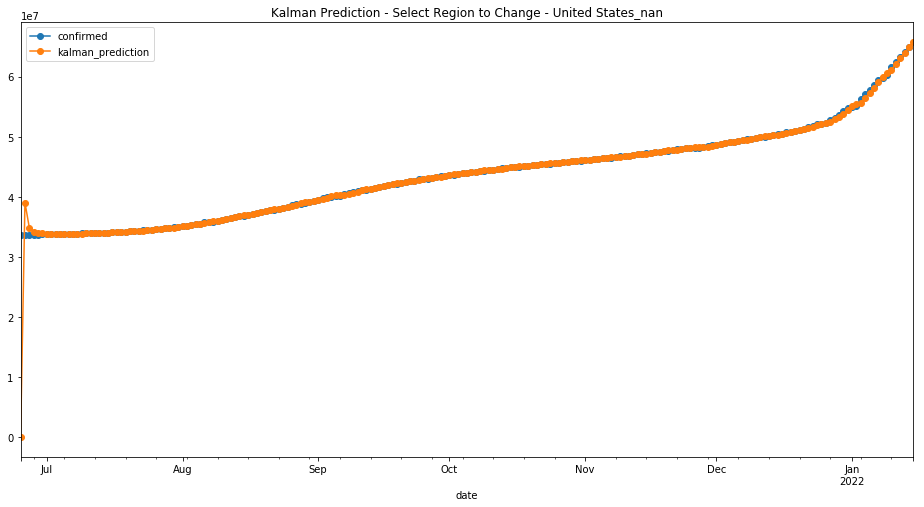

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
217  Russia_nan  5.521969e+11  743099.490314  59738.151961


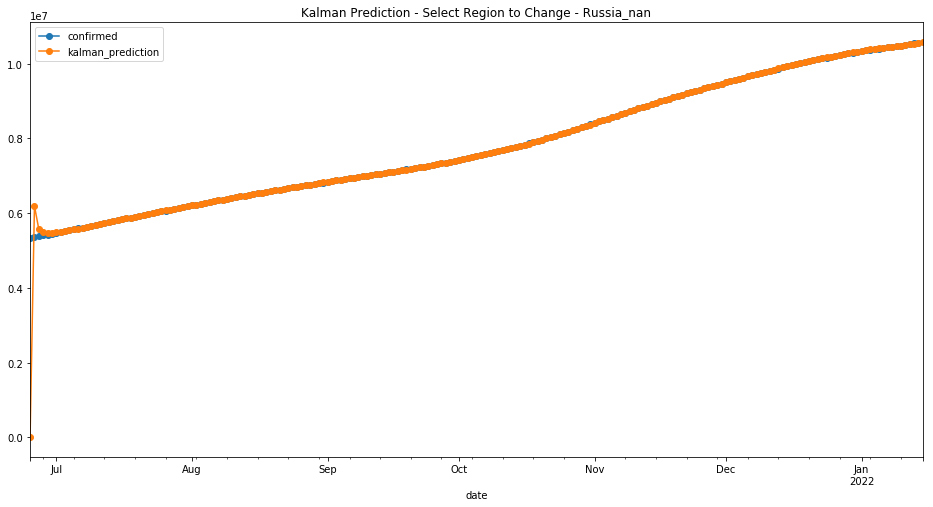

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
30  Brazil_nan  2.628539e+12  1.621277e+06  144795.392157


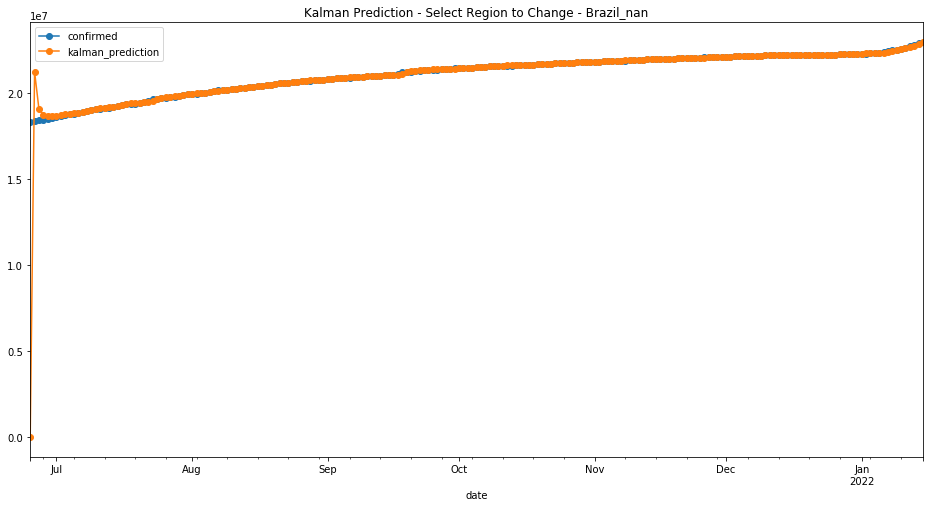

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse           mae
269  United Kingdom_nan  1.139249e+12  1.067356e+06  91376.416667


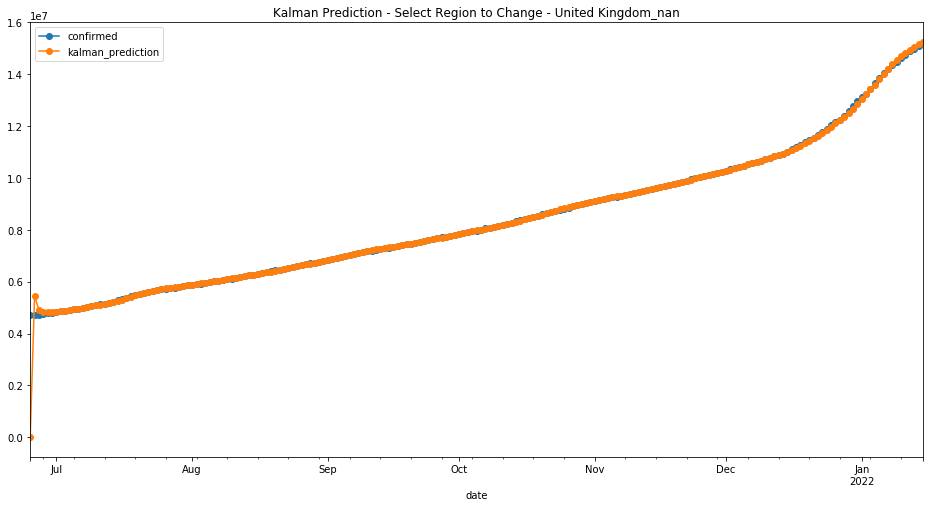

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp4nrdry2r
  JVM stdout: /tmp/tmp4nrdry2r/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp4nrdry2r/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 2 months and 19 days !!!
H2O cluster name:           H2O_from_python_unknownUser_esz3s1
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-01-03
last_train_date= 2022-01-14
first_bootstrap_date= 2022-01-06
boost_bootstrap_date= 2022-01-11
first_test_date= 2022-01-05
last_test_date= 2022-01-15
first_valid_date= 2022-01-13


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   159969.0     158275 2022-01-06  Afghanistan_nan
1   160006.0     158300 2022-01-07  Afghanistan_nan
2   160034.0     158309 2022-01-08  Afghanistan_nan
3   160056.0     158381 2022-01-09  Afghanistan_nan
4   160072.0     158394 2022-01-10  Afghanistan_nan
5   160134.0     158471 2022-01-11  Afghanistan_nan
6   160163.0     158511 2022-01-12  Afghanistan_nan
7   160236.0     158602 2022-01-13  Afghanistan_nan
8   160293.0     158639 2022-01-14  Afghanistan_nan
9   160383.0          0 2022-01-15  Afghanistan_nan
10  213585.0     213257 2022-01-06      Albania_nan
11  214118.0     214905 2022-01-07      Albania_nan
12  215453.0     214905 2022-01-08      Albania_nan
13  216674.0     219694 2022-01-09      Albania_nan
14  218661.0     220487 2022-01-10      Albania_nan
15  222183.0     222664 2022-01-11      Albania_nan
16  224173.0     224569 2022-01-12      Albania_nan
17  226660.0     226598 2022-01-13      Albania_nan
18  228881.0     228777 2022-01-14      Albania_nan
19  231138.0          0 2022-01-15      Albania_nan
20  222353.0     220825 2022-01-06      Algeria_nan
21  222807.0     221316 2022-01-07      Algeria_nan
22  223269.0     221742 2022-01-08      Algeria_nan
23  223752.0     222157 2022-01-09      Algeria_nan
24  224199.0     222639 2022-01-10      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  623027.0     622236 2022-01-11  Azerbaijan_nan
176  623641.0     622881 2022-01-12  Azerbaijan_nan
177  624275.0     623555 2022-01-13  Azerbaijan_nan
178  624952.0     624208 2022-01-14  Azerbaijan_nan
179  625642.0          0 2022-01-15  Azerbaijan_nan
180   26714.0      26701 2022-01-06     Bahamas_nan
181   26935.0      27122 2022-01-07     Bahamas_nan
182   27207.0      27122 2022-01-08     Bahamas_nan
183   29188.0      28619 2022-01-09     Bahamas_nan
184   23876.0      28968 2022-01-10     Bahamas_nan
185   29596.0      29489 2022-01-11     Bahamas_nan
186   29574.0      29730 2022-01-12     Bahamas_nan
187   30993.0      29908 2022-01-13     Bahamas_nan
188   31418.0      29908 2022-01-14     Bahamas_nan
189   32016.0          0 2022-01-15     Bahamas_nan
190  286445.0     287939 2022-01-06     Bahrain_nan
191  287859.0     289454 2022-01-07     Bahrain_nan
192  289483.0     290878 2022-01-08     Bahrain_nan
193  291145.0     292572 2022-01-09     Bahrain_nan
194  292907.0     294466 2022-01-10     Bahrain_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date       region
220   705362.0     704907 2022-01-06  Belarus_nan
221   706528.0     706530 2022-01-07  Belarus_nan
222   708029.0     707714 2022-01-08  Belarus_nan
223   709385.0     708291 2022-01-09  Belarus_nan
224   710280.0     708931 2022-01-10  Belarus_nan
225   711020.0     709622 2022-01-11  Belarus_nan
226   711653.0     710632 2022-01-12  Belarus_nan
227   712450.0     711723 2022-01-13  Belarus_nan
228   713378.0     713002 2022-01-14  Belarus_nan
229   714530.0          0 2022-01-15  Belarus_nan
230  2188750.0    2206992 2022-01-06  Belgium_nan
231  2219129.0    2231686 2022-01-07  Belgium_nan
232  2248362.0    2231686 2022-01-08  Belgium_nan
233  2256722.0    2231686 2022-01-09  Belgium_nan
234  2260391.0    2286532 2022-01-10  Belgium_nan
235  2305109.0    2307843 2022-01-11  Belgium_nan
236  2326302.0    2347164 2022-01-12  Belgium_nan
237  2366710.0    2347164 2022-01-13  Belgium_nan
238  2375216.0    2410731 2022-01-14  Belgium_nan
239  2434264.0          0 2022-01-15  Belgium_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  111315761715.3247
# MSE on the validation data =  62623527427351.16
# R^2 on the training data =  0.9987279777580926
# R^2 on the validation data =  0.4125078228492165


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1642228094866_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 111315761715.3247
RMSE: 333640.16801836784
MAE: 21470.29516839001
RMSLE: 0.5093082937133139
Mean Residual Deviance: 111315761715.3247

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 62623527427351.16
RMSE: 7913502.8544476535
MAE: 2231613.2596753757
RMSLE: 8.220218269439599
Mean Residual Deviance: 62623527427351.16
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2022-01-15 06:28:22  0.059 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2022-01-15 06:28:22  0.456 sec   1.0                380827.84427980165  44749.05517247423   145029846978.80087   7828043.067712423   2211841.9638231983  61278258269960.52
     2022-01-15 06:28:23  0.619 sec   2.0                163554.01292758127  35434.762291951905  26749915144.715424   7844078.614866049   2188848.269728549   61529569316198.87
     2022-01-15 06:28:23  0.848 sec   3.0                169022.04769380583  35099.6727282653    28568452606.607174   7847387.9594298545  2188974.8159643635  61581497785804.66
     2022-01-15 06:28:23  1.019 sec   4.0                264781.8694317489   36034.755911282875  70109438379.77174    7959076.580313689   2217186.635867368   63346900011297.84
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2022-01-15 06:28:30  8.067 sec   124.0              328432.6140890766   23812.57259745858   107867981997.38432   7949904.612164845   2238618.592131457   63200983342519.875
     2022-01-15 06:28:34  12.095 sec  225.0              330684.8279404225   22673.76856587817   109352455429.98686   7929260.050550914   2231479.1899977615  62873164949262.695
     2022-01-15 06:28:38  16.123 sec  324.0              321092.444887979    21824.893517890287  103100358164.13985   7927216.310666585   2233664.7489272254  62840758436098.34
     2022-01-15 06:28:42  20.139 sec  421.0              323048.32002507243  21473.135794956866  104360217071.02162   7925715.177042373   2231998.409114094   62816961067599.82
     2022-01-15 06:28:46  23.548 sec  500.0              333640.16801836784  21470.29516839001   111315761715.3247    7913502.8544476535  2231613.2596753757  62623527427351.16


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
region             1.04872e+20            1                    0.338615
kalman_prediction  9.17679e+19            0.875042             0.296302
last_day           6.74554e+19            0.643214             0.217802
7_day_change       1.88292e+19            0.179544             0.0607963
3_day_change       1.09476e+19            0.10439              0.0353478
1_day_change       6.87019e+18            0.0655099            0.0221826
infected_rate      6.06169e+18            0.0578006            0.0195721
7_day_change_rate  1.52459e+18            0.0145375            0.00492262
3_day_change_rate  8.26197e+17            0.00787811           0.00266764
1_day_change_rate  5.5505e+17             0.00529262           0.00179216

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0             region         1.048725e+20           1.000000    0.338615
1  kalman_prediction         9.176785e+19           0.875042    0.296302
2           last_day         6.745545e+19           0.643214    0.217802
3       7_day_change         1.882922e+19           0.179544    0.060796
4       3_day_change         1.094759e+19           0.104390    0.035348
5       1_day_change         6.870187e+18           0.065510    0.022183
6      infected_rate         6.061691e+18           0.057801    0.019572
7  7_day_change_rate         1.524587e+18           0.014538    0.004923
8  3_day_change_rate         8.261967e+17           0.007878    0.002668
9  1_day_change_rate         5.550497e+17           0.005293    0.001792

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


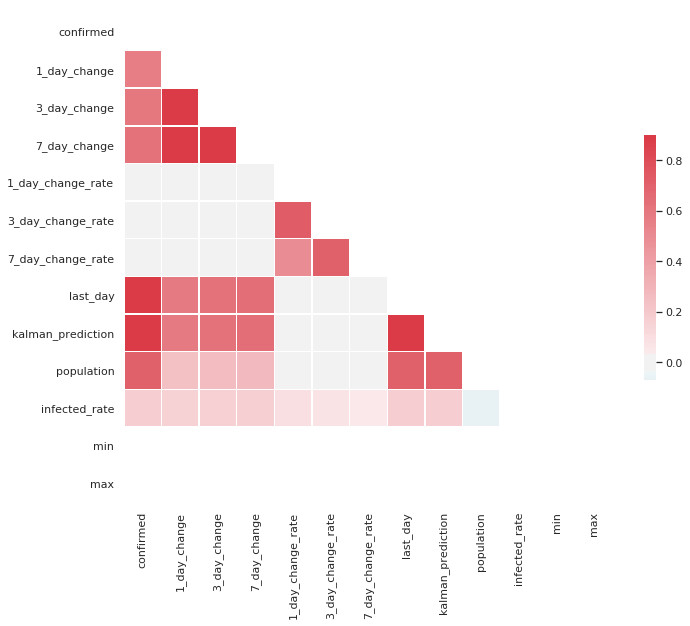

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.564720
3_day_change         0.600612
7_day_change         0.622789
1_day_change_rate    0.014072
3_day_change_rate    0.007157
7_day_change_rate   -0.000611
last_day             0.991990
kalman_prediction    0.993593
population           0.710557
infected_rate        0.178015
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


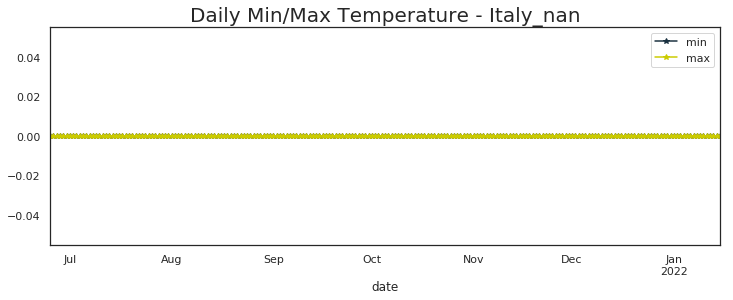

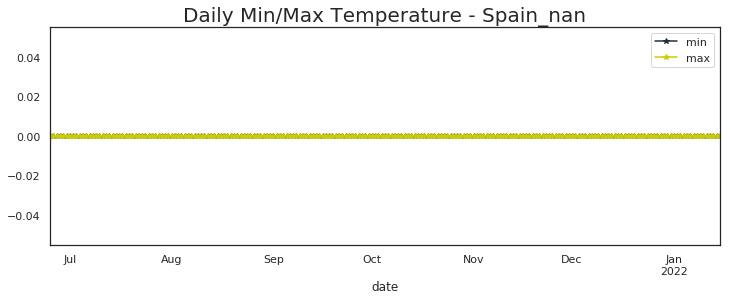

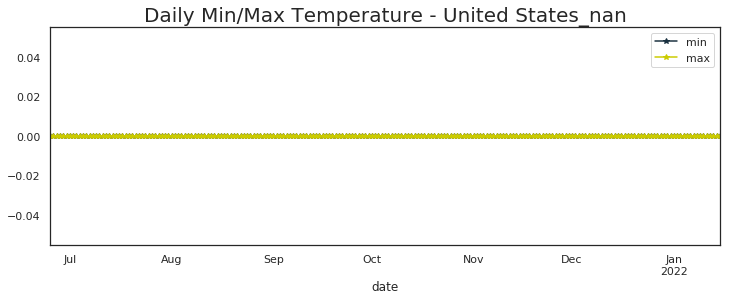

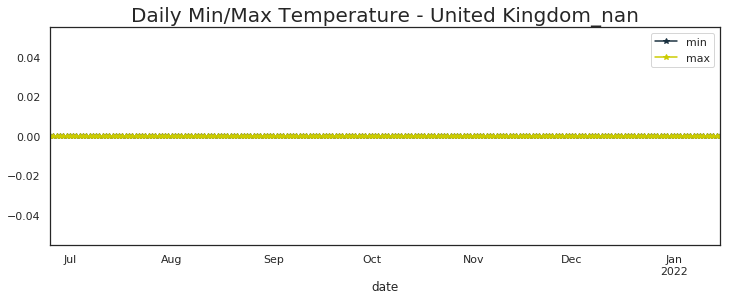

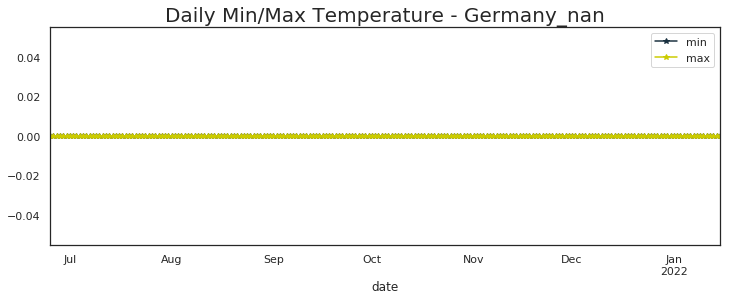

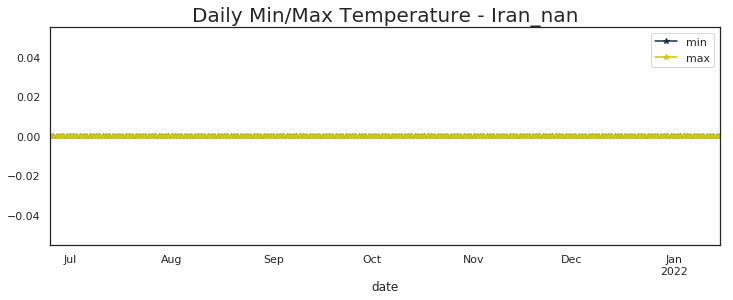

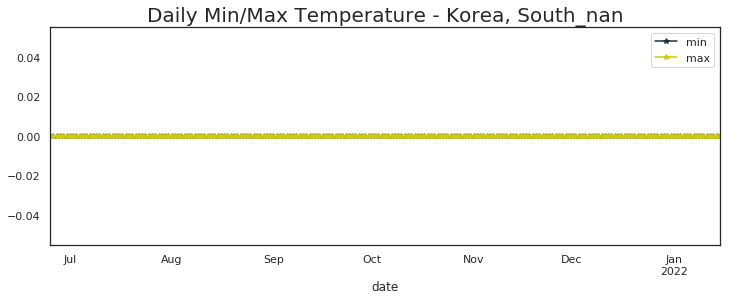

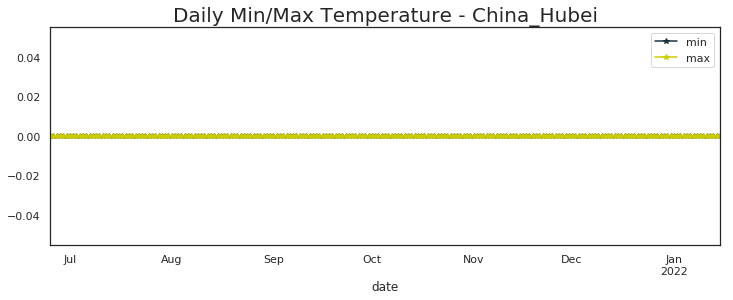

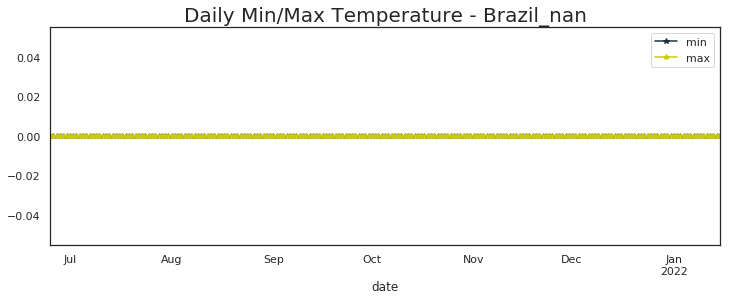

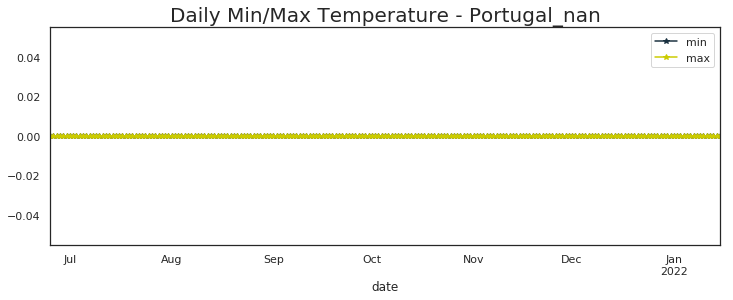

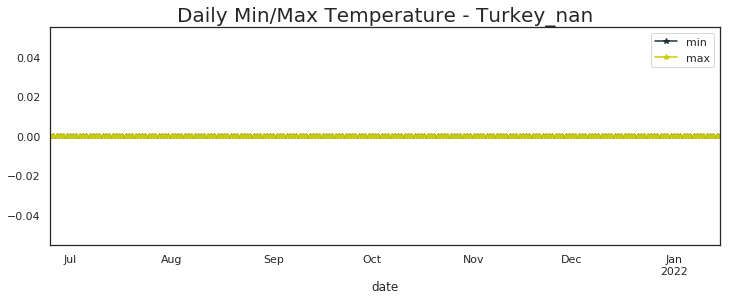

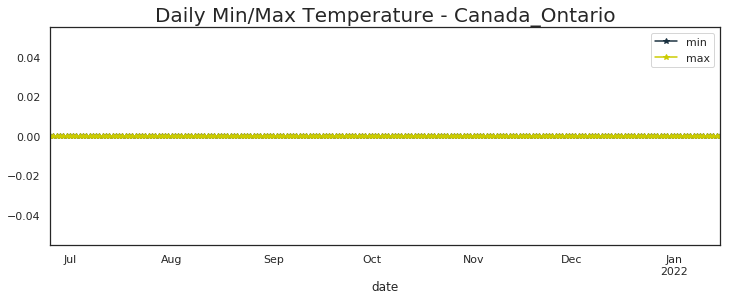

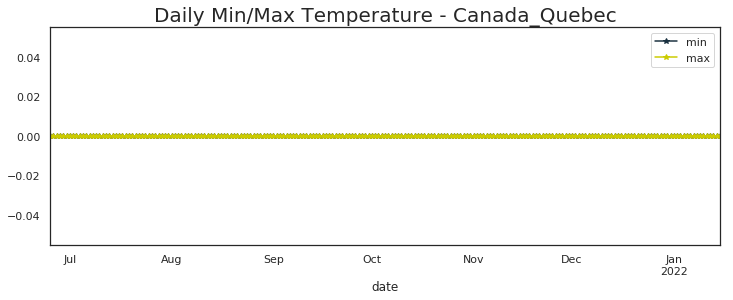

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
United Kingdom_nan          0.0  0.0
France_nan                  0.0  0.0
Russia_nan                  0.0  0.0
Turkey_nan                  0.0  0.0
Italy_nan                   0.0  0.0
Spain_nan                   0.0  0.0
Germany_nan                 0.0  0.0
Argentina_nan               0.0  0.0
Iran_nan                    0.0  0.0
Colombia_nan                0.0  0.0
Poland_nan                  0.0  0.0
Indonesia_nan               0.0  0.0
Mexico_nan                  0.0  0.0
Ukraine_nan                 0.0  0.0
South Africa_nan            0.0  0.0
Netherlands_nan             0.0  0.0
Philippines_nan             0.0  0.0
Malaysia_nan                0.0  0.0
Czechia_nan                 0.0  0.0
Peru_nan                    0.0  0.0
Belgium_nan                 0.0  0.0
Th

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

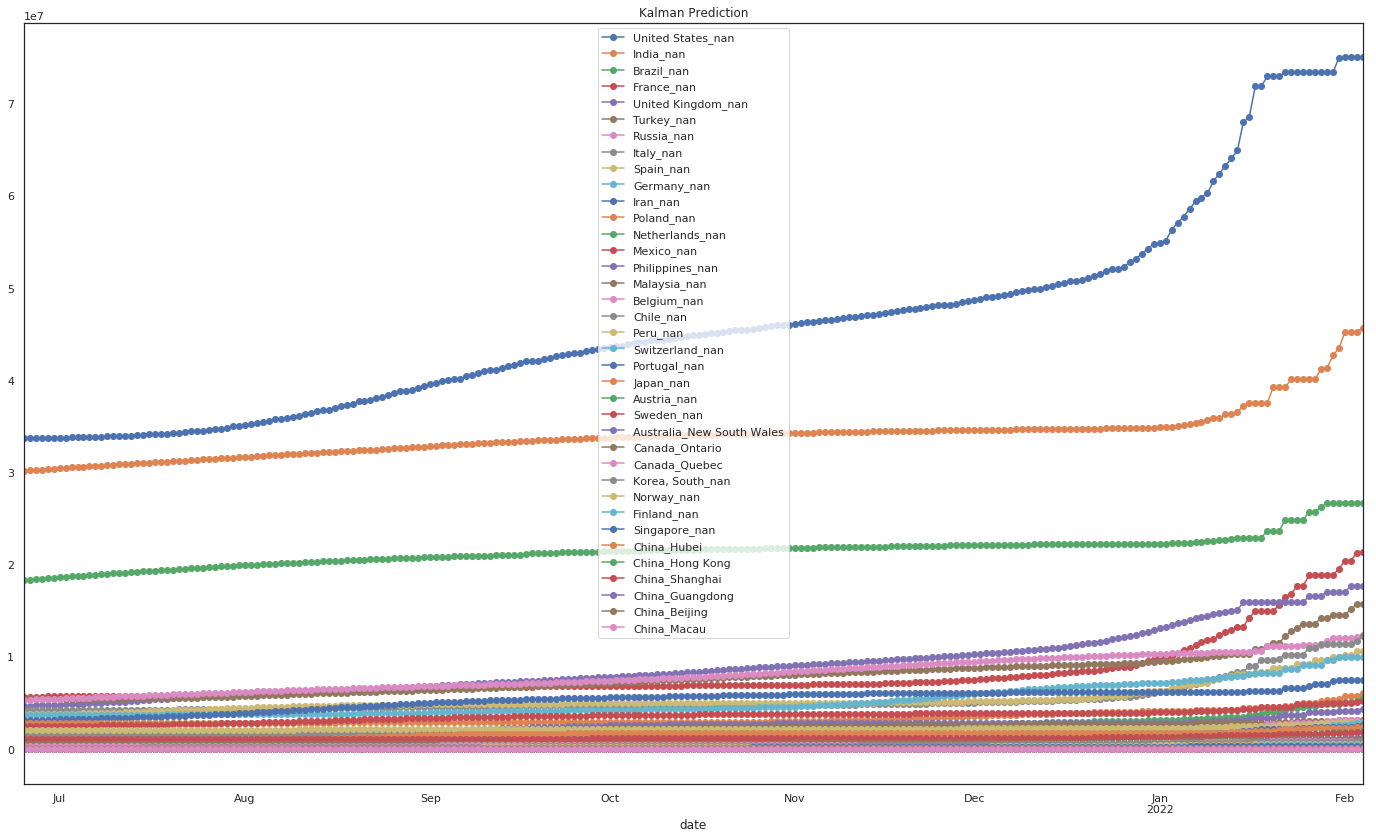

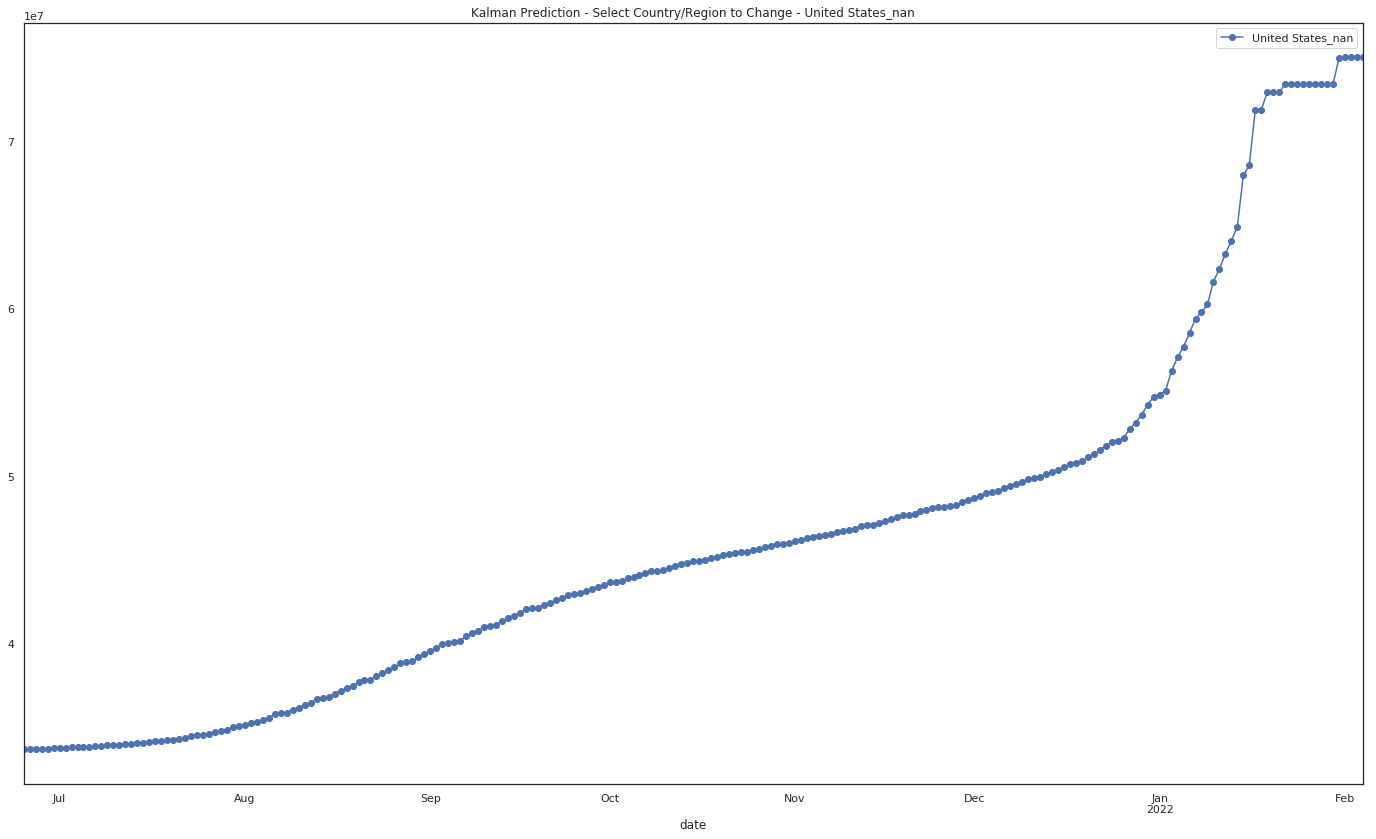

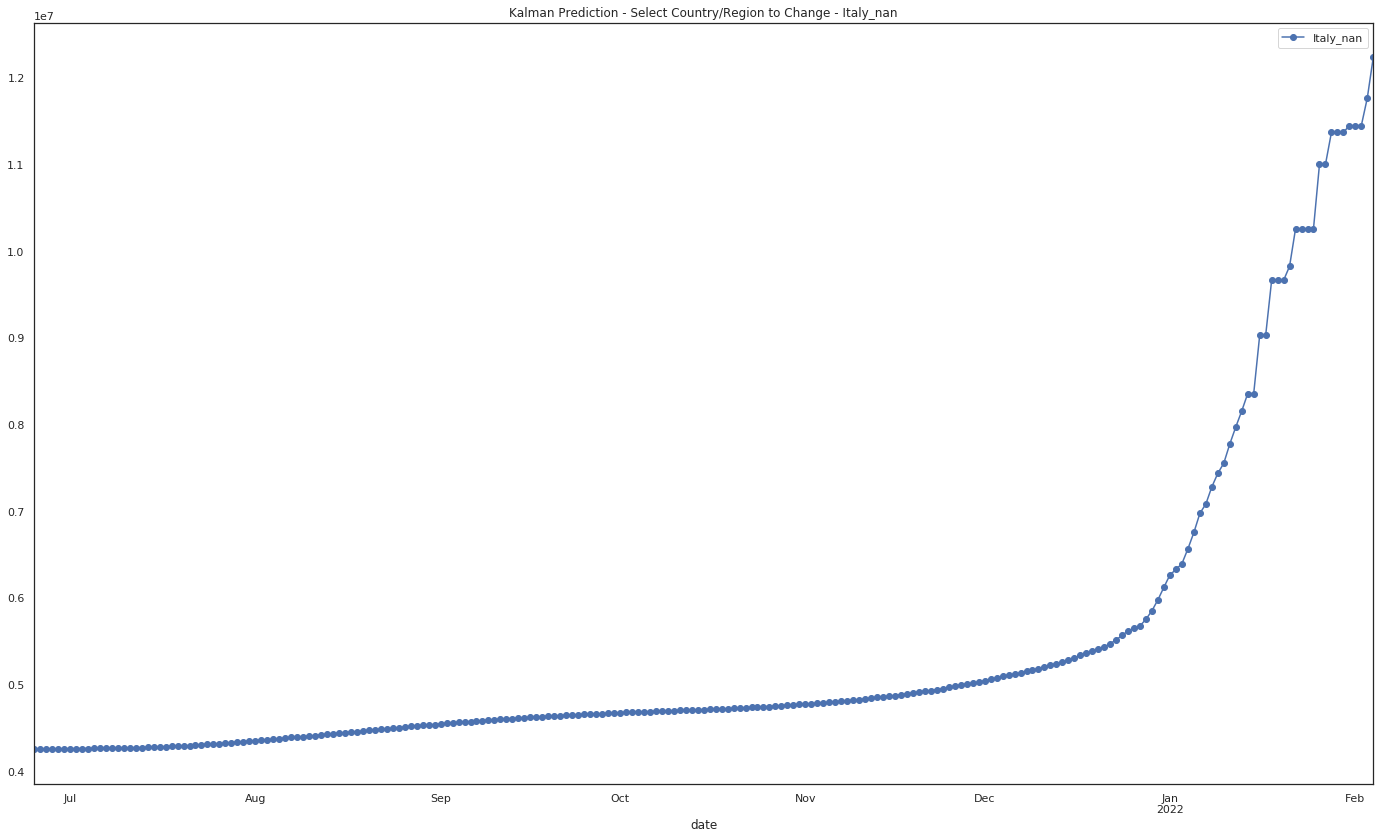

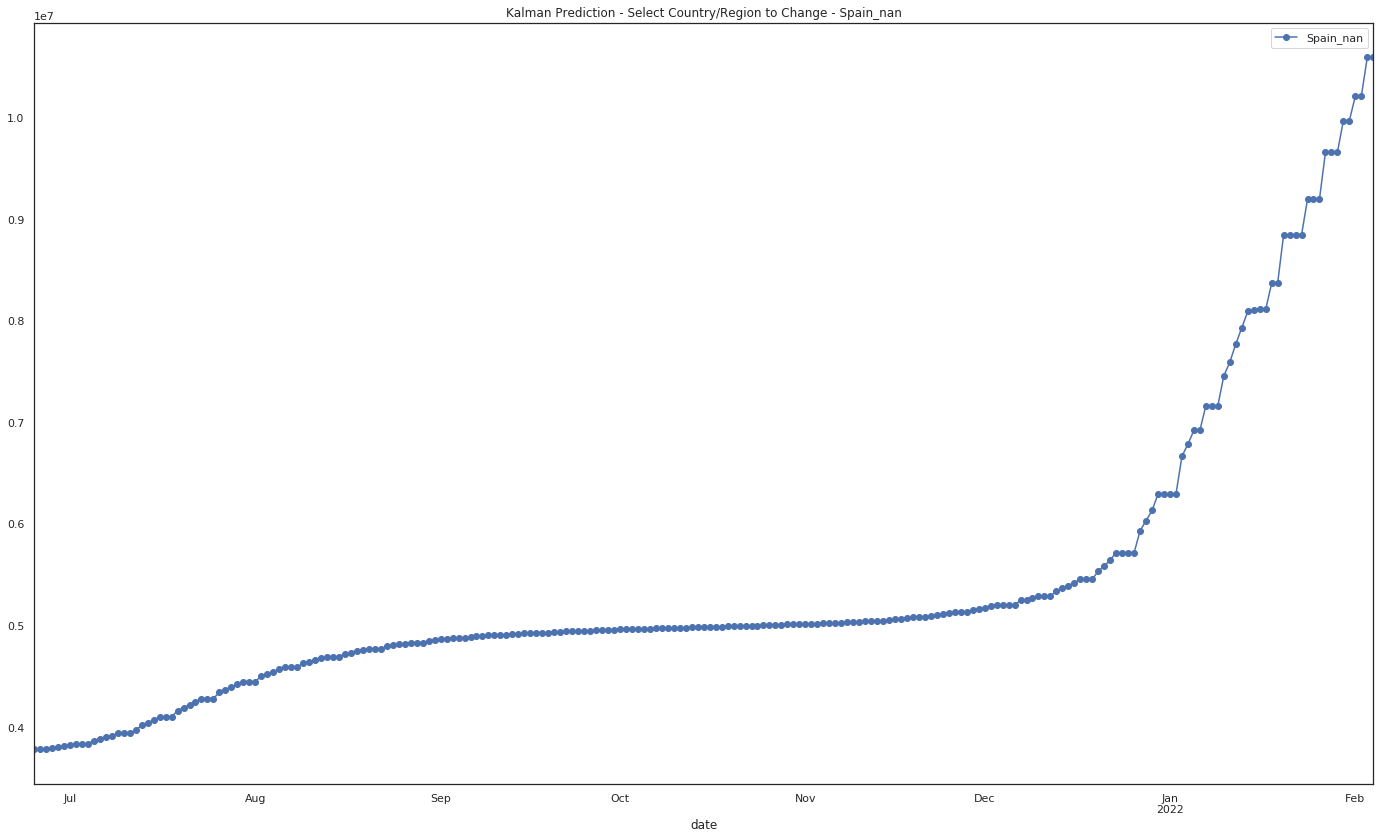

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


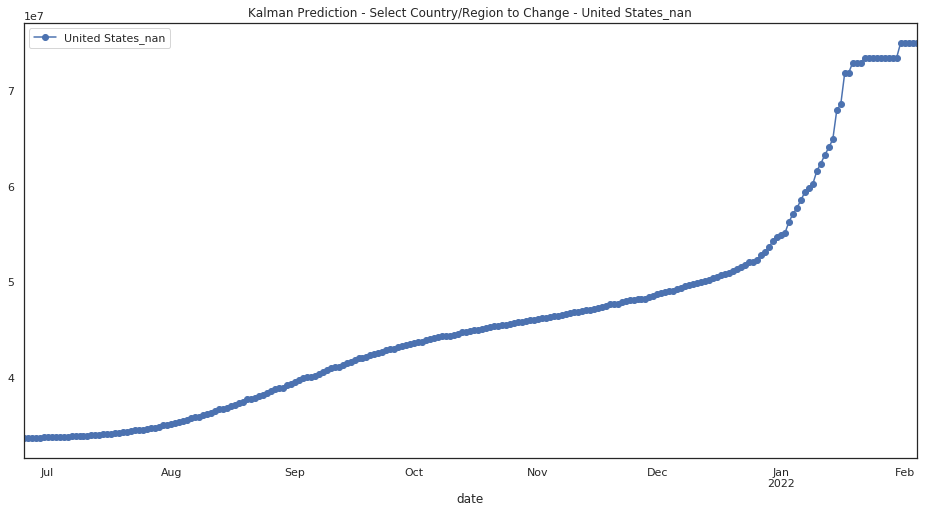

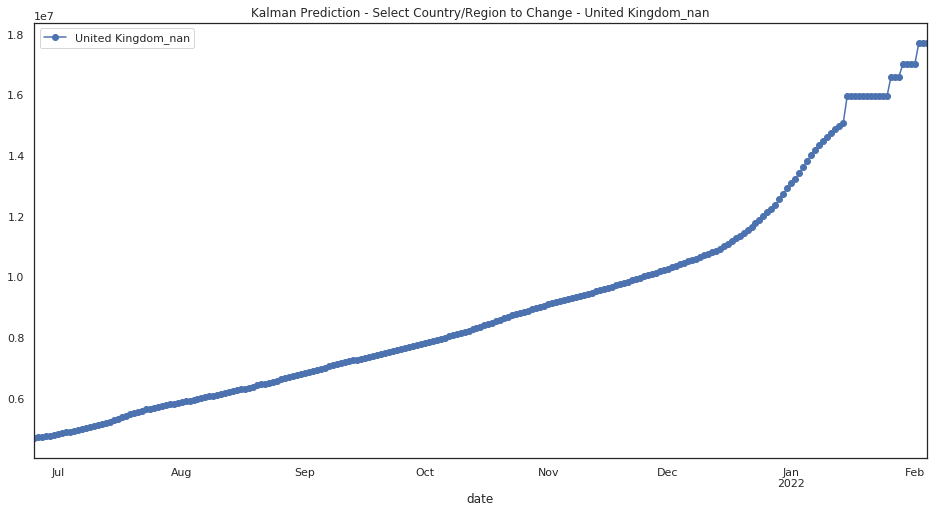

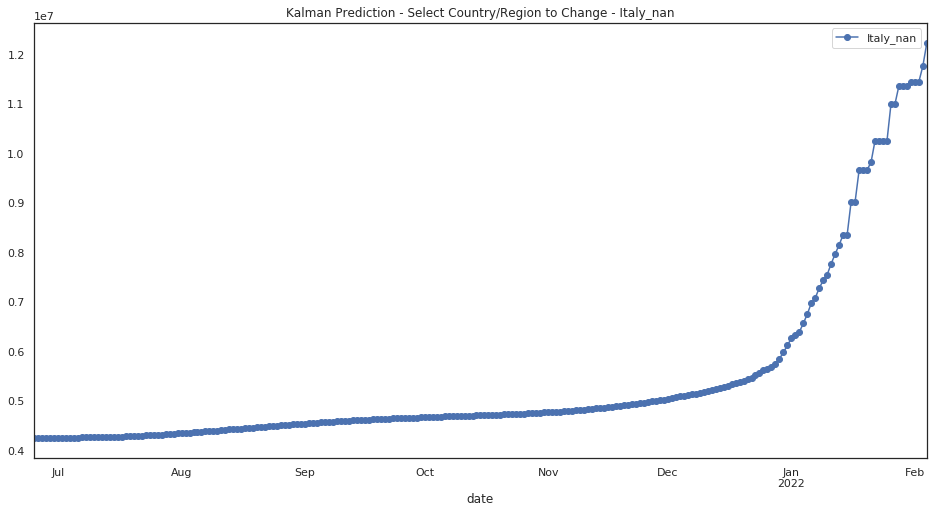

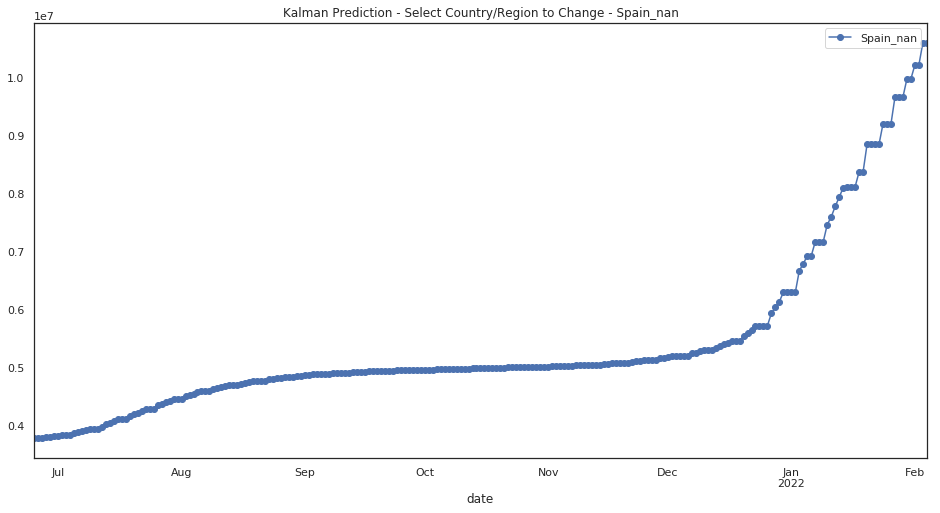

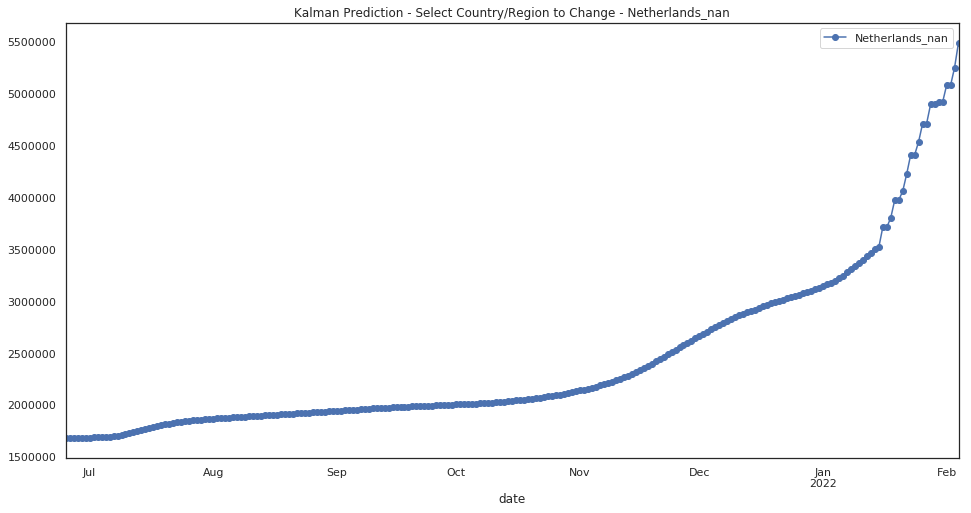

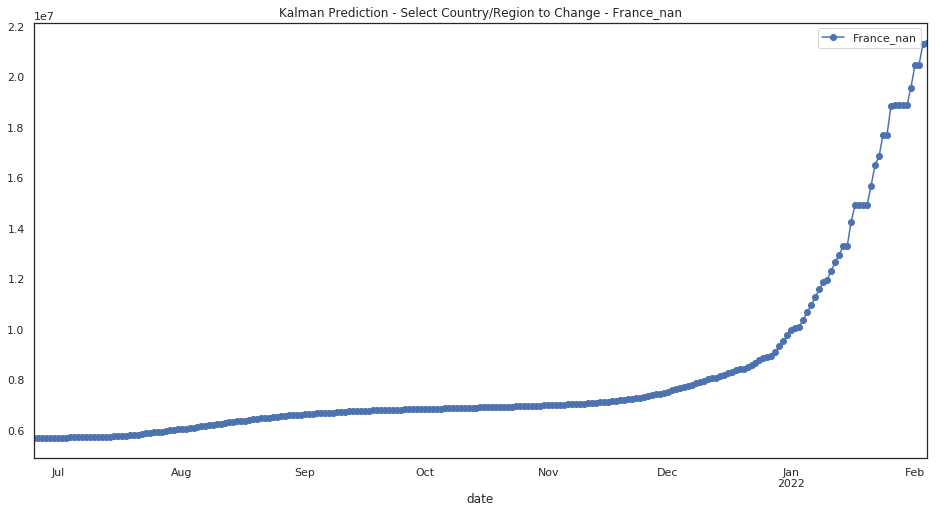

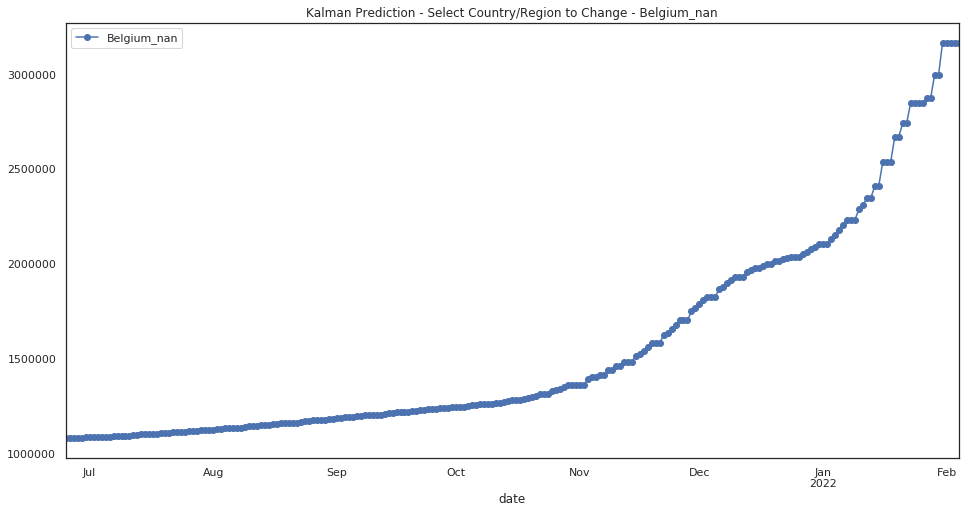

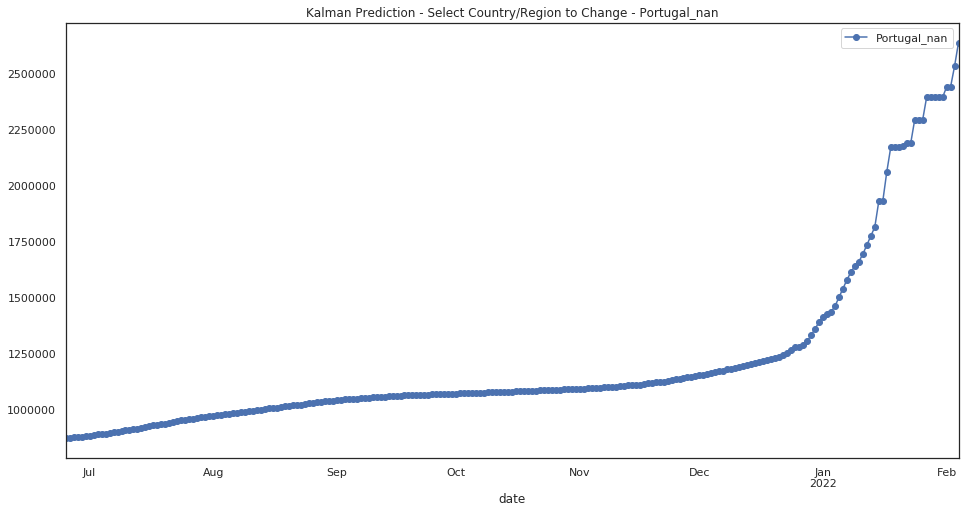

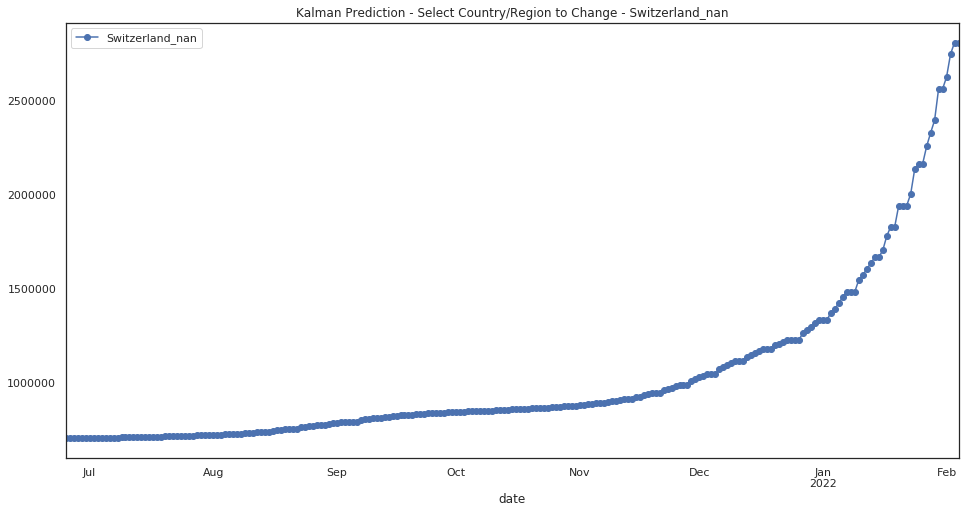

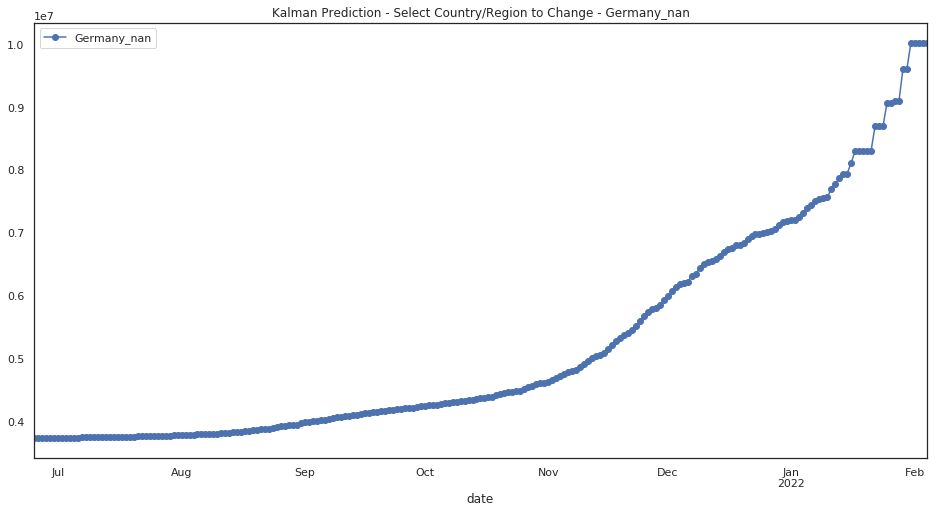

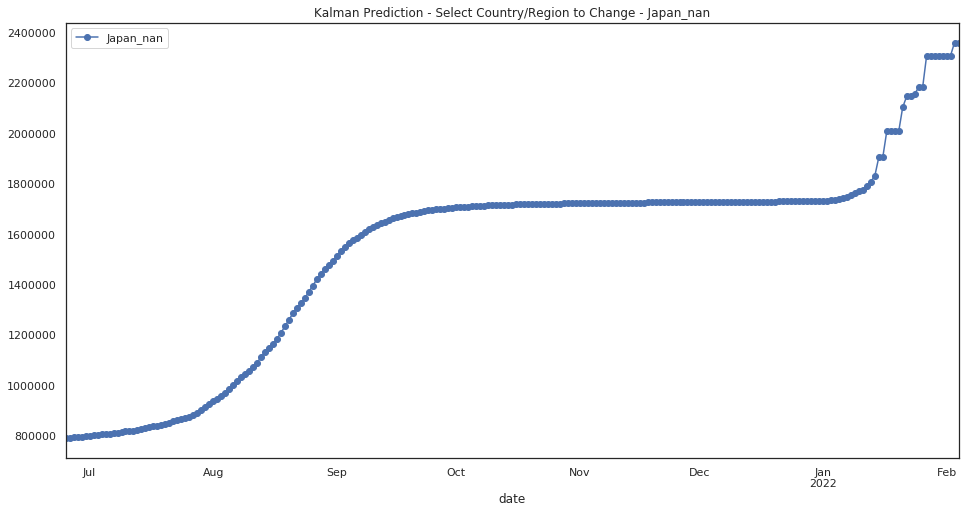

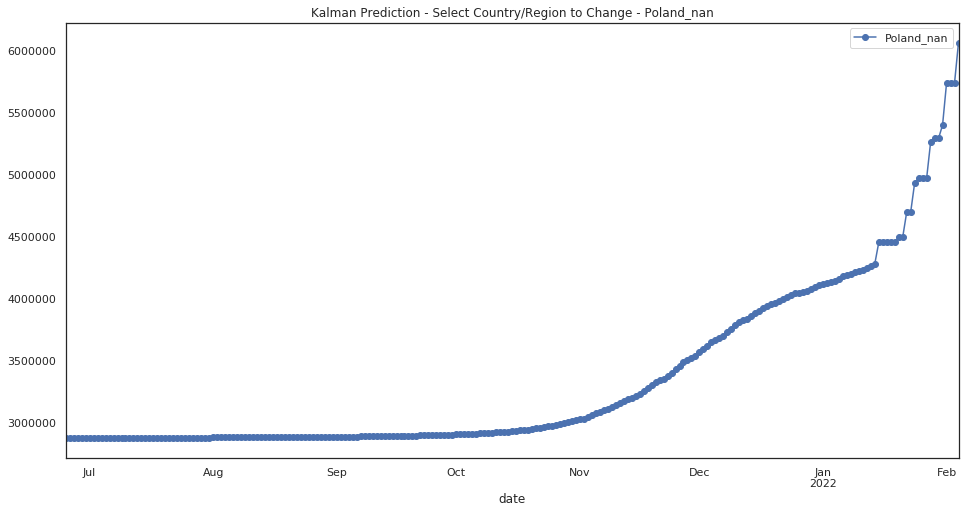

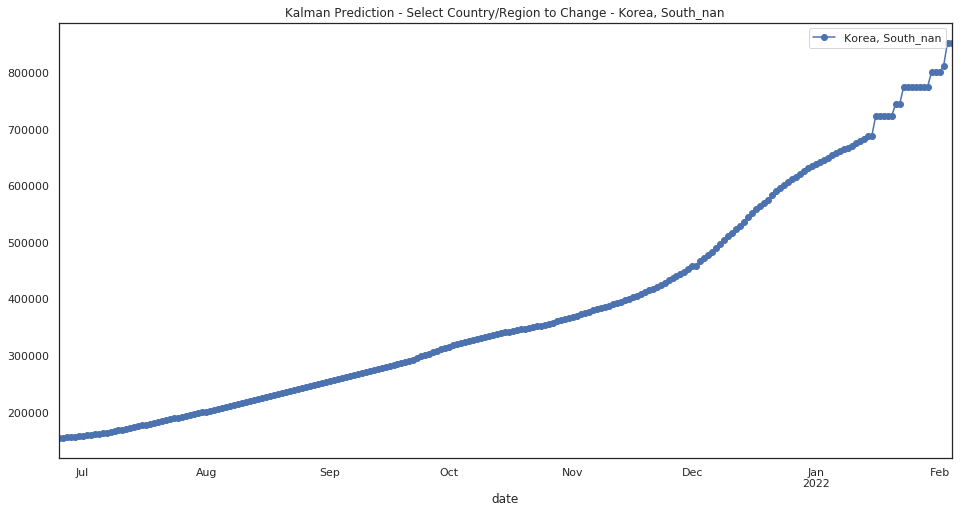

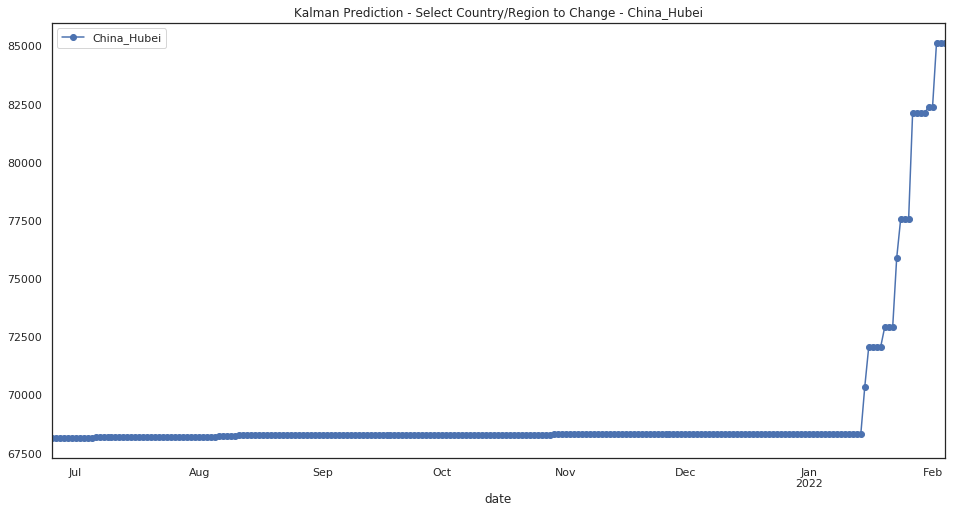

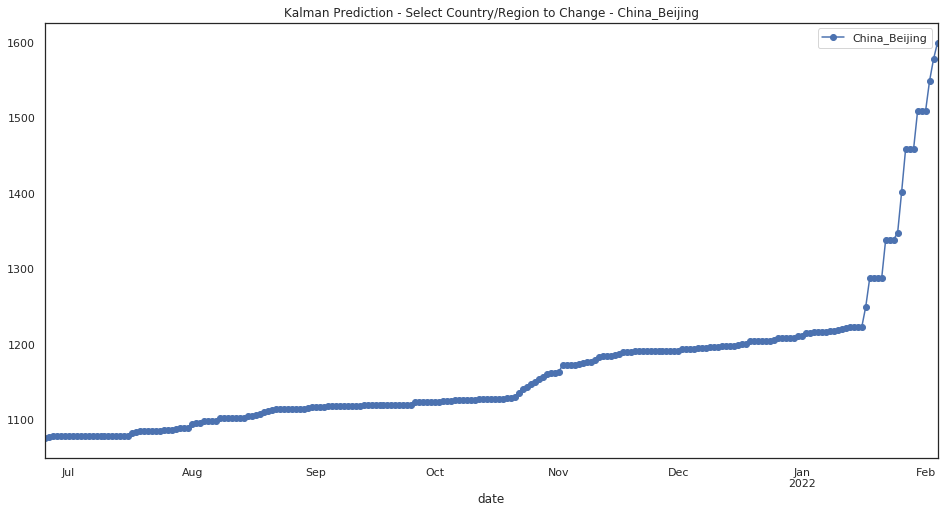

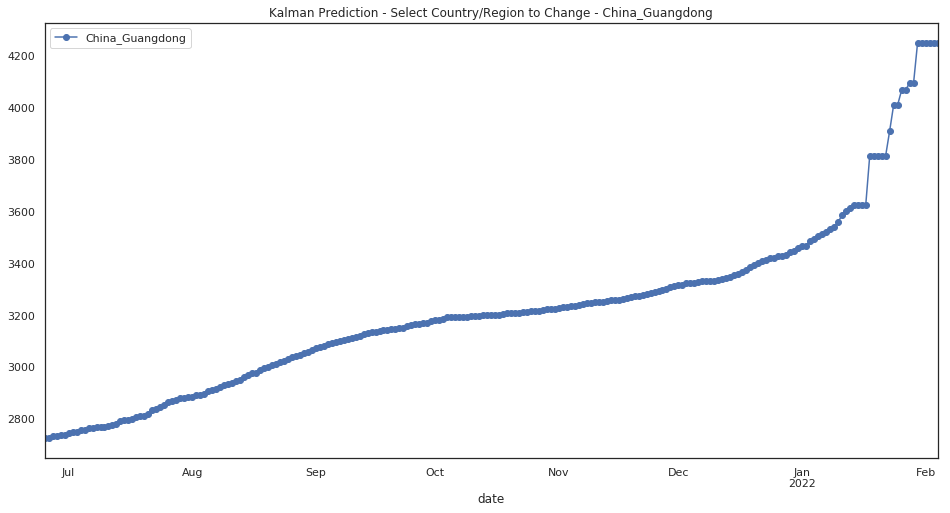

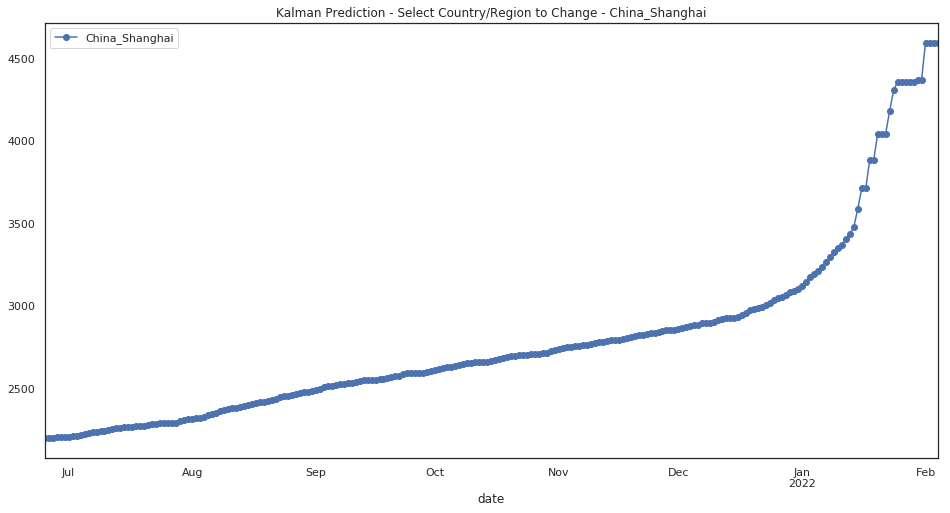

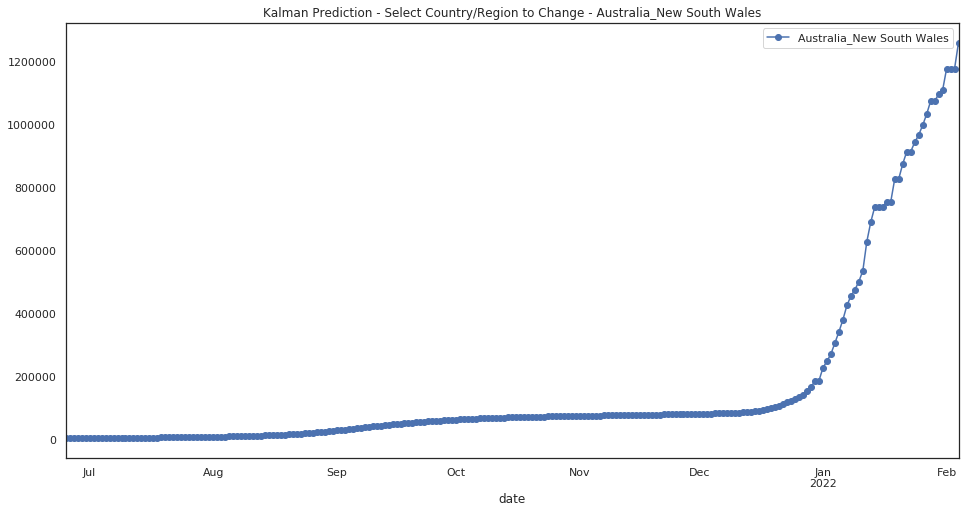

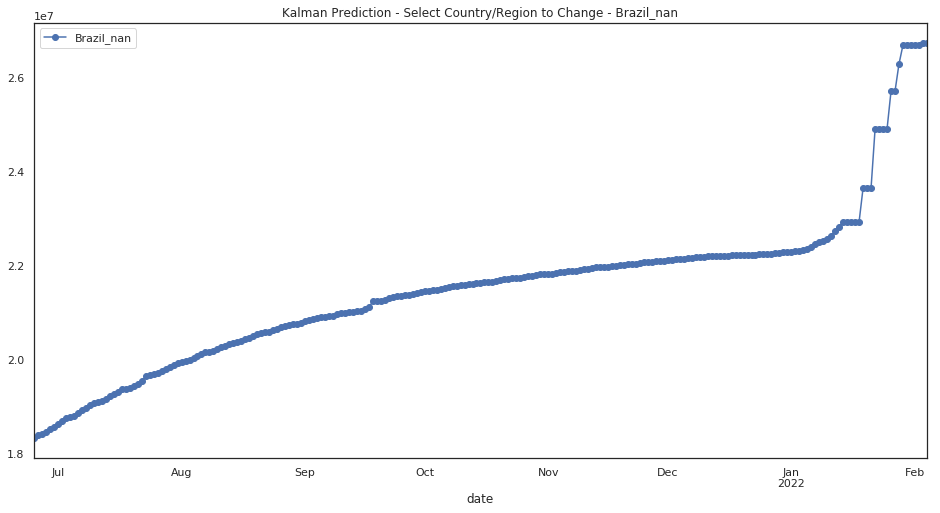

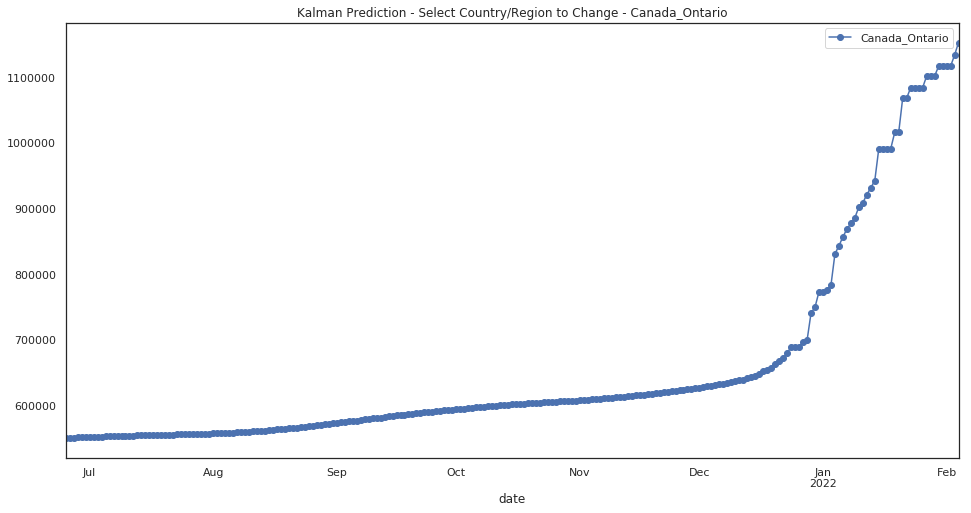

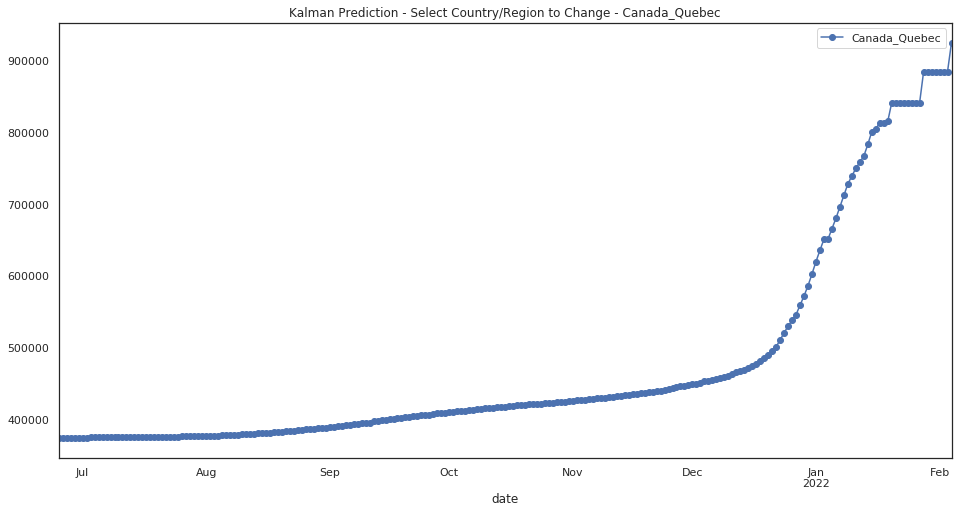

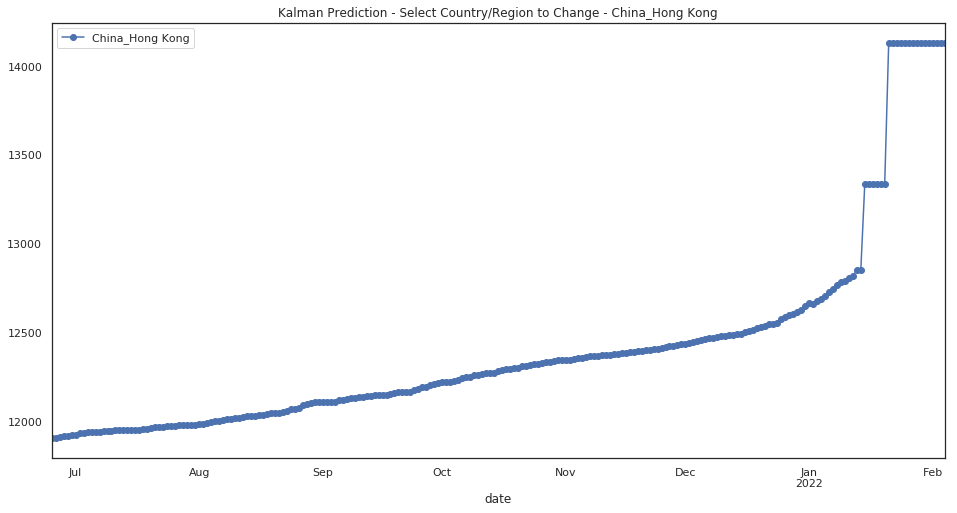

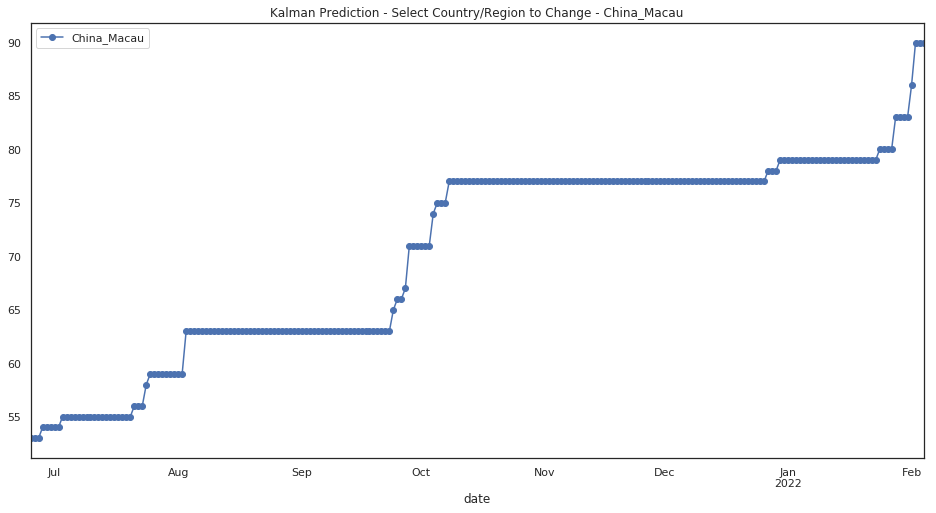

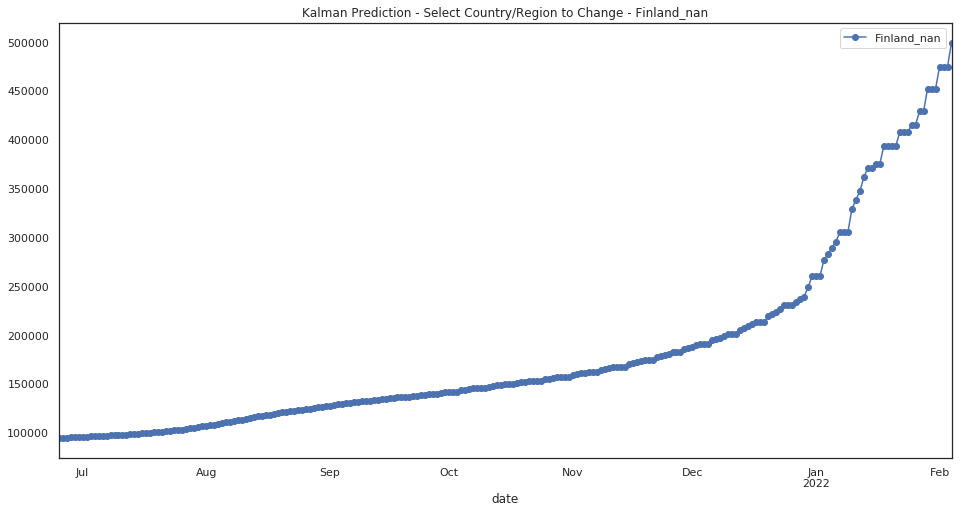

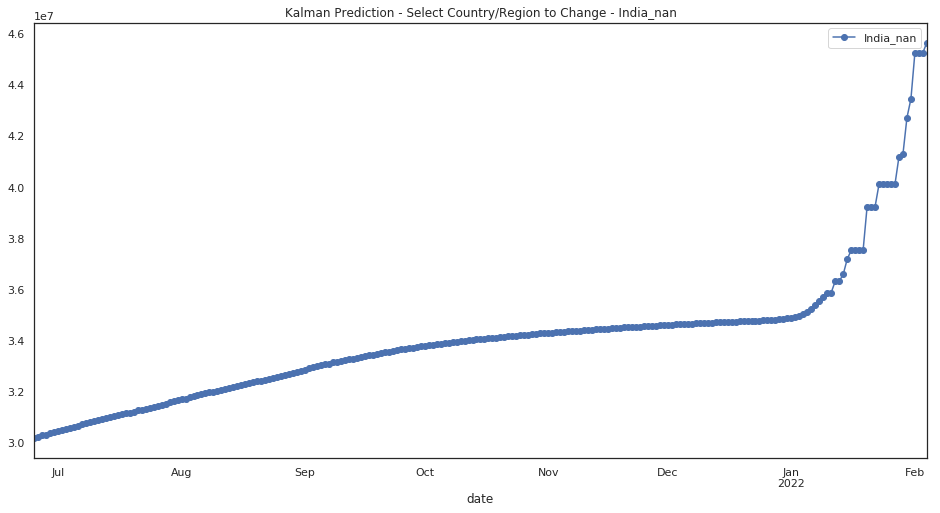

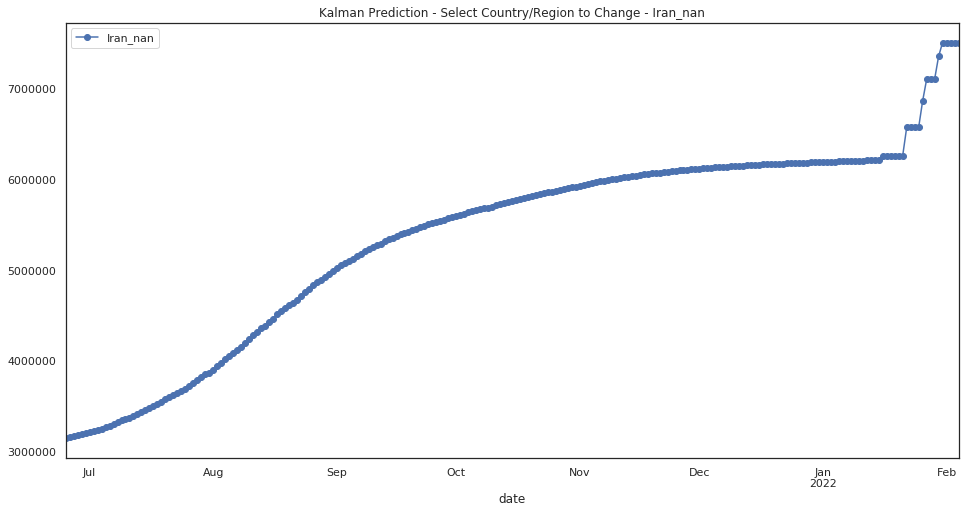

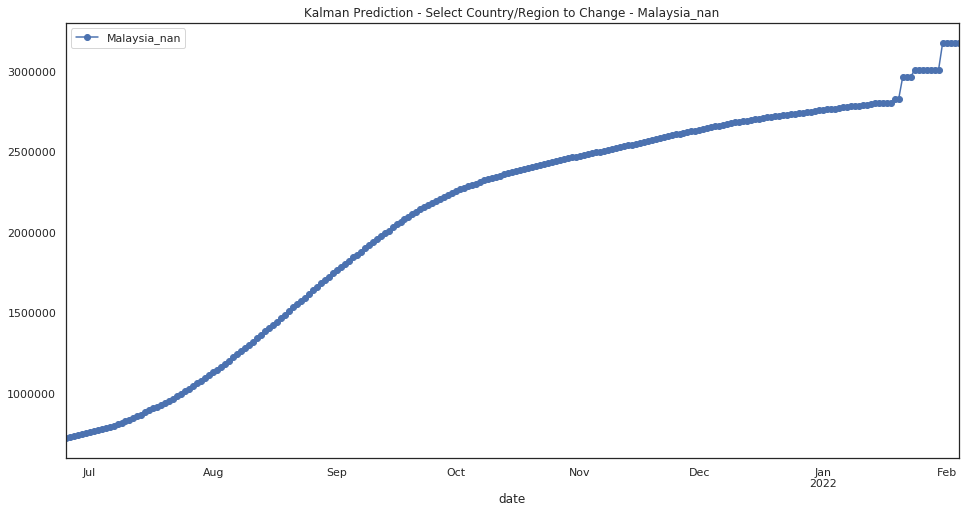

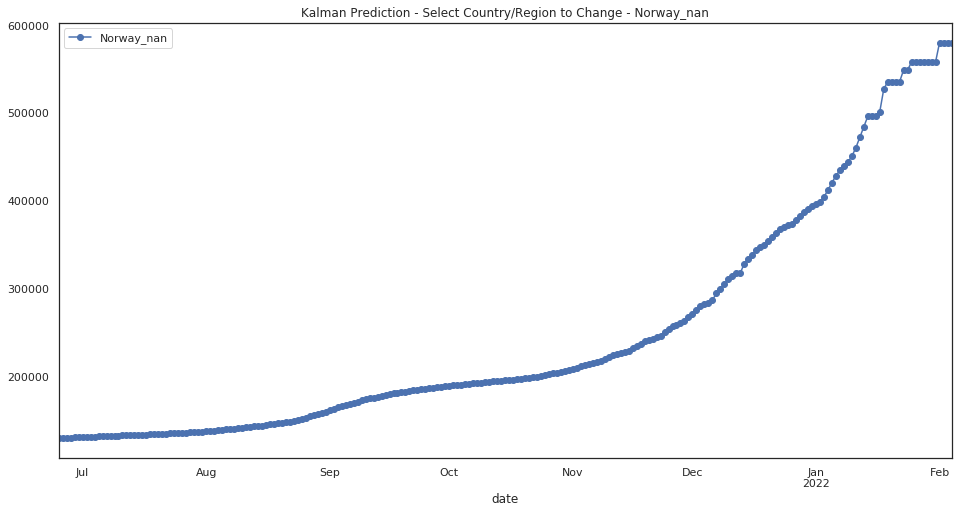

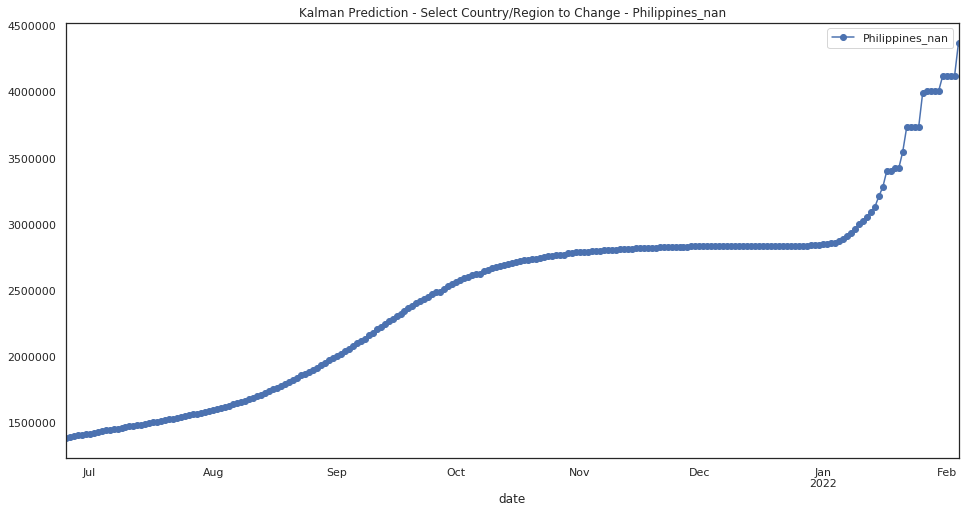

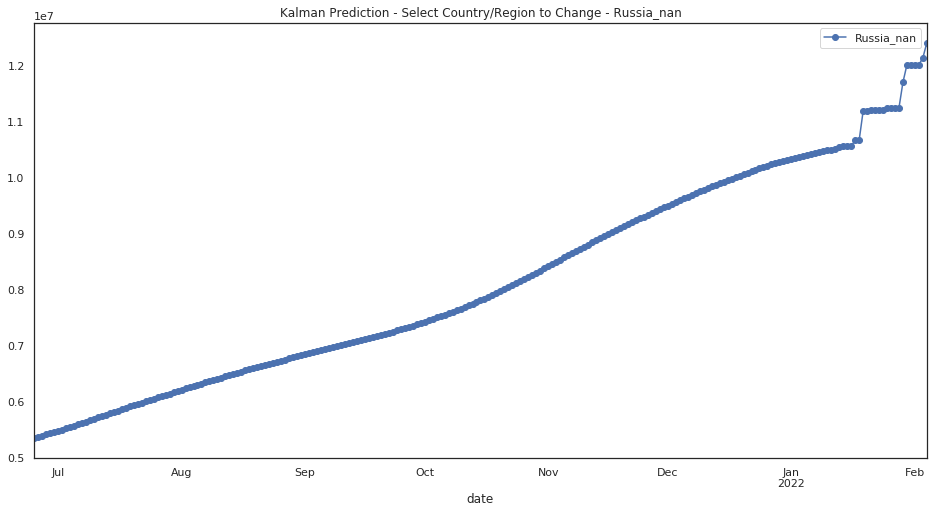

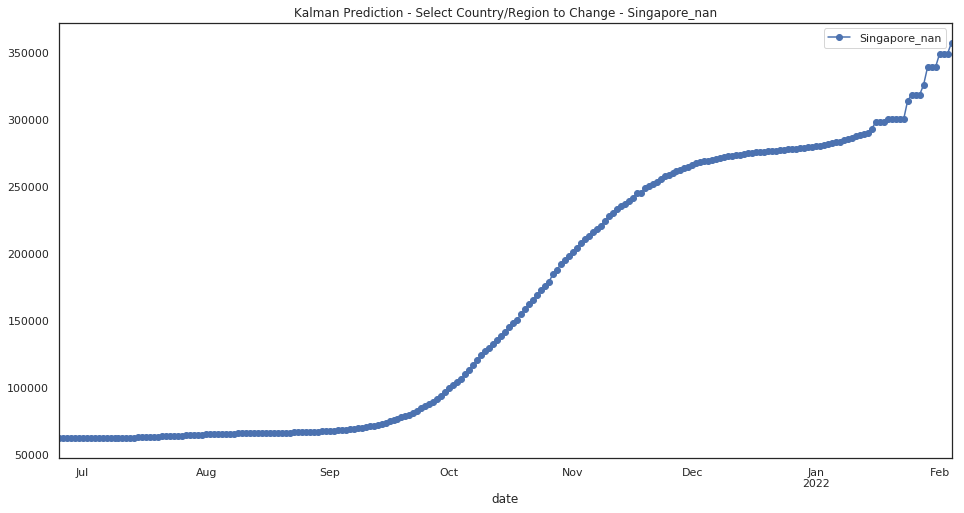

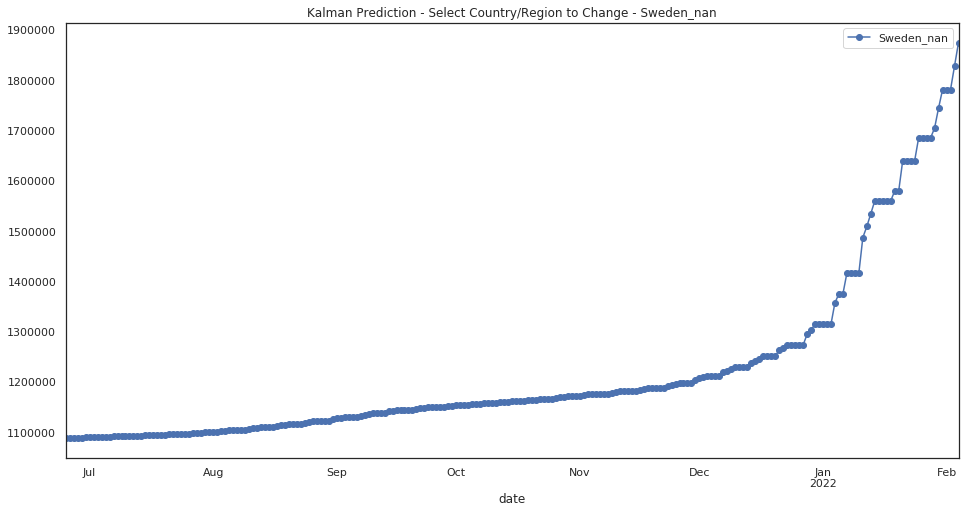

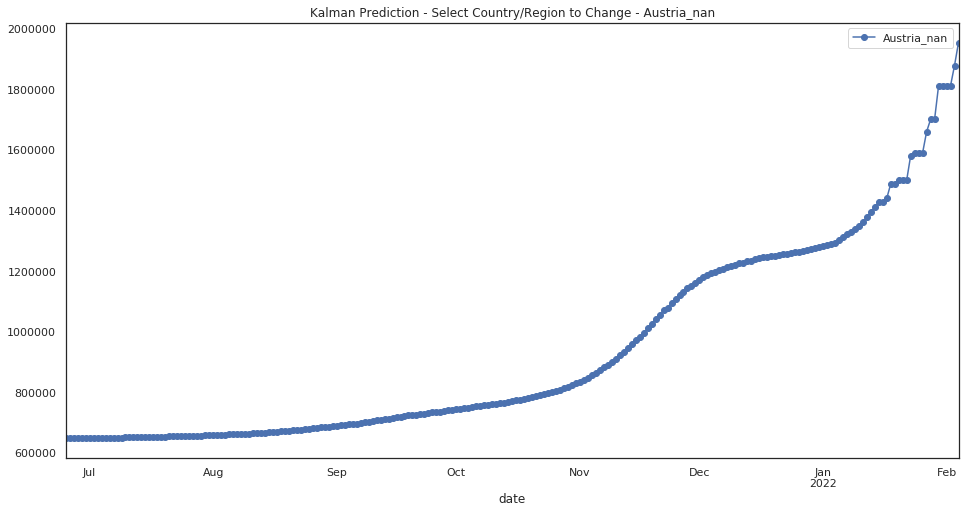

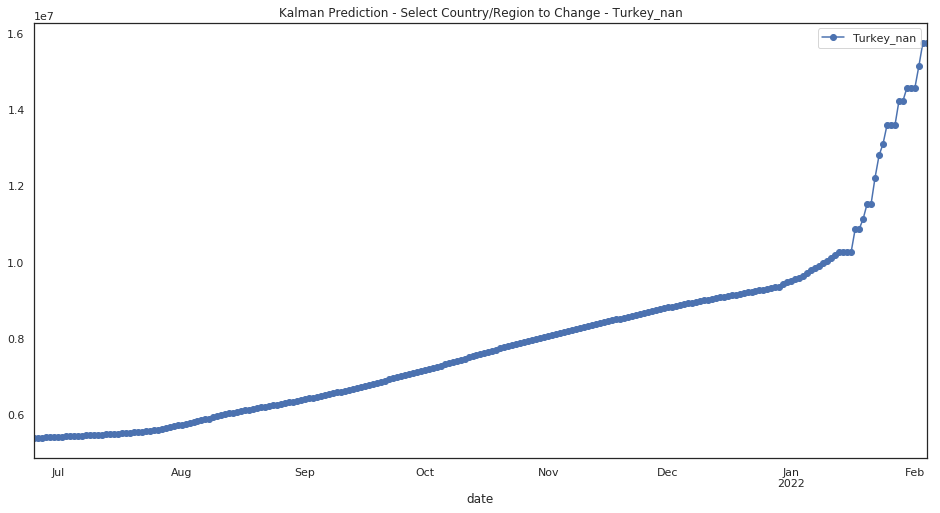

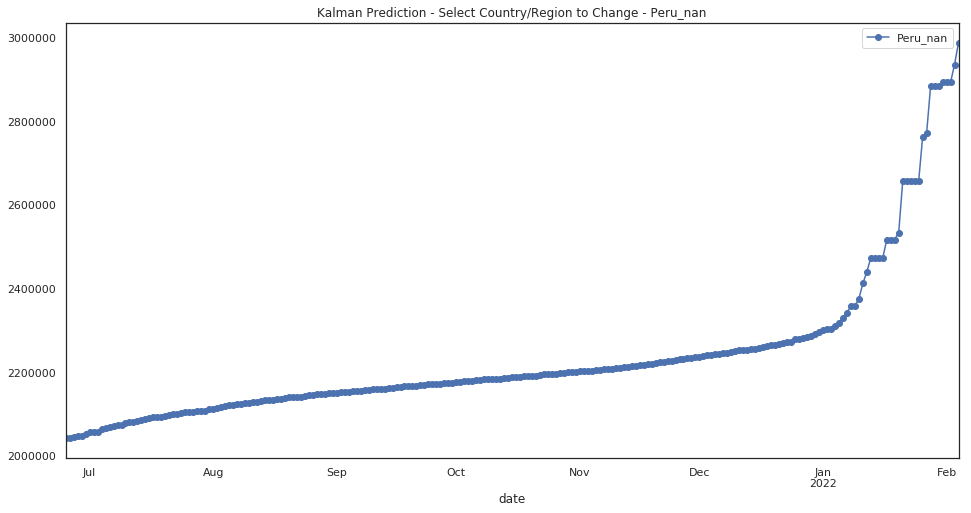

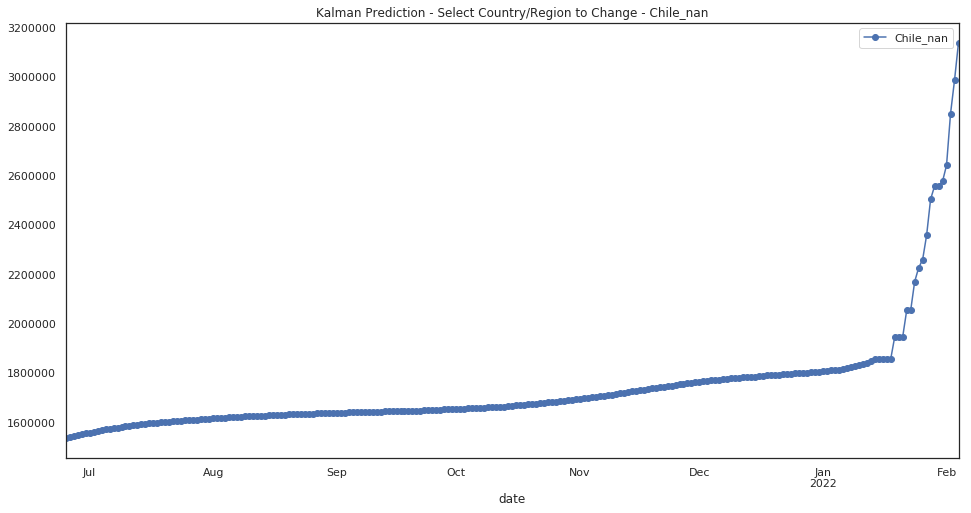

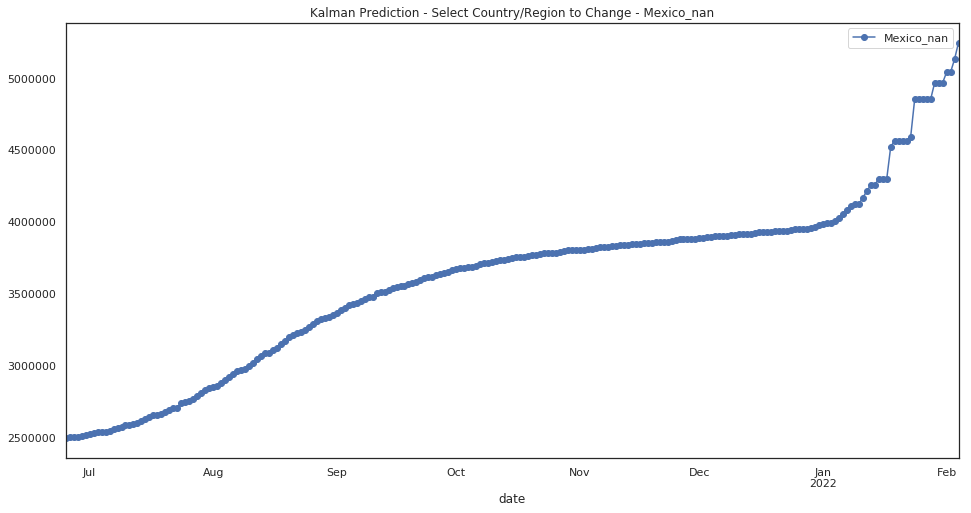

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-02-04 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN      75029990.0
India_nan                                           NaN      45661843.0
Brazil_nan                                          NaN      26738522.0
France_nan                                          NaN      21353127.0
United Kingdom_nan                                  NaN      17724036.0
Turkey_nan                                          NaN      15762122.0
Russia_nan                                          NaN      12414882.0
Italy_nan                                           NaN      12235014.0
Spain_nan                                           NaN      10595854.0
Germany_nan                                         NaN      10028809.0
Argentina_nan                                       NaN       9688069.0
Iran_nan                                            NaN       7512508.0
Colombia_nan                                        NaN       6689532.0
Poland_nan                                          NaN       6062016.0
Netherlands_nan                                     NaN       5494762.0
Mexico_nan                                          NaN       5247498.0
Indonesia_nan                                       NaN       4783053.0
Ukraine_nan                                         NaN       4380161.0
Philippines_nan                                     NaN       4373658.0
South Africa_nan                                    NaN       4136875.0
Czechia_nan                                         NaN       3460649.0
Malaysia_nan                                        NaN       3180197.0
Belgium_nan                                         NaN       3166199.0
Chile_nan                                           NaN       3138595.0
Thailand_nan                                        NaN       3095320.0
Peru_nan                                            NaN       2988495.0
Greece_nan                                          NaN       2943317.0
Switzerland_nan                                     NaN       2811319.0
Iraq_nan                                            NaN       2723272.0
Romania_nan                                         NaN       2661505.0
...                                                 ...             ...
France_Saint Pierre and Miquelon                    NaN           850.0
China_Chongqing                                     NaN           728.0
China_Jilin                                         NaN           625.0
France_Wallis and Futuna                            NaN           514.0
China_Gansu                                         NaN           507.0
China_Shanxi                                        NaN           307.0
China_Hainan                                        NaN           202.0
China_Guizhou                                       NaN           184.0
United Kingdom_Montserrat                           NaN           164.0
China_Ningxia                                       NaN           154.0
China_Unknown                                       NaN           105.0
United Kingdom_Falkland Islands (Malvinas)          NaN            97.0
China_Macau                                         NaN            90.0
China_Qinghai                                       NaN            37.0
Holy See_nan                                        NaN            34.0
Solomon Islands_nan                                 NaN            31.0
Canada_Grand Princess                               NaN            19.0
Canada_Repatriated Travellers                       NaN            16.0
MS Zaandam_nan                                      NaN             9.0
Palau_nan                                           NaN             8.0
Vanuatu_nan                                         NaN             7.0
Marshall Islands_nan                                NaN             7.0
United Kingdom_Saint Helena, Ascension and Tris...  NaN             4.0
Samoa_nan                                           NaN             3.0
Kiribati_nan          

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-06-25         214700.0     232600.0     237107.0     131071.0   
2021-06-26         216011.0     232603.0     237399.0     131071.0   
2021-06-27         113124.0     132509.0     138113.0      13882.0   
2021-06-28         114220.0     132512.0     138465.0      13882.0   
2021-06-29         115751.0     132513.0     138840.0      13882.0   
2021-06-30         117158.0     132514.0     139229.0      13900.0   
2021-07-01         118659.0     132521.0     139626.0      13911.0   
2021-07-02         120216.0     132523.0     140075.0      13918.0   
2021-07-03         124216.0     133778.0     142530.0      13918.0   
2021-07-04         125975.0     133776.0     143012.0      13918.0   
2021-07-05         127246.0     133783.0     143506.0      13918.0   
2021-07-06         128764.0     133789.0     143977.0      13918.0   
2021-07-07         130076.0     133798.0     144563.0      13991.0   
2021-07-08         131228.0     133803.0     145123.0      14021.0   
2021-07-09         132964.0     133820.0     145913.0      14050.0   
2021-07-10         133893.0     133824.0     146618.0      14075.0   
2021-07-11         134952.0     133835.0     147428.0      14075.0   
2021-07-12         136236.0     133842.0     148338.0      14075.0   
2021-07-13         137253.0     133852.0     149228.0      14155.0   
2021-07-14         137951.0     133857.0     150139.0      14167.0   
2021-07-15         139376.0     133871.0     151259.0      14167.0   
2021-07-16         140277.0     133885.0     152358.0      14239.0   
2021-07-17         141449.0     133899.0     153452.0      14273.0   
2021-07-18         141961.0     133920.0     154627.0      14273.0   
2021-07-19         143282.0     133932.0     155822.0      14273.0   
2021-07-20         143847.0     133977.0     157080.0      14359.0   
2021-07-21         144248.0     133983.0     158269.0      14379.0   
2021-07-22         144997.0     134030.0     159546.0      14379.0   
2021-07-23         145182.0     134055.0     160893.0      14464.0   
2021-07-24         145461.0     134083.0     162139.0      14498.0   
...                     ...          ...          ...          ...   
2022-01-07         160001.0     215327.0     222910.0      25289.0   
2022-01-08         160014.0     215430.0     223323.0      26408.0   
2022-01-09         160086.0     220098.0     223763.0      26408.0   
2022-01-10         160072.0     219990.0     224243.0      26408.0   
2022-01-11         160173.0     223388.0     224773.0      27983.0   
2022-01-12         160186.0     224902.0     225357.0      28542.0   
2022-01-13         160290.0     227135.0     225928.0      28899.0   
2022-01-14         160310.0     229279.0     226539.0      28899.0   
2022-01-15         162604.0     229572.0     226624.0      29888.0   
2022-01-16         161700.0     230272.0     226798.0      29888.0   
2022-01-17         163137.0     230041.0     226783.0      29888.0   
2022-01-18         163136.0     230025.0     233690.0      29888.0   
2022-01-19         165952.0     229911.0     233070.0      31239.0   
2022-01-20         170120.0     229877.0     235113.0      31239.0   
2022-01-21         175386.0     235540.0     235083.0      31239.0   
2022-01-22         177159.0     235604.0     235146.0      32257.0   
2022-01-23         179689.0     236660.0     242728.0      33336.0   
2022-01-24         179730.0     236661.0     244548.0      33336.0   
2022-01-25         185880.0     238113.0     246862.0      33336.0   
2022-01-26         184285.0     245718.0     250888.0      35280.0   
2022-01-27         195734.0     246301.0     250631.0      35280.0   
2022-01-28         194689.0     247805.0     254967.0      35280.0   
2022-01-29         198345.0     254557.0     254670.0      35744.0   
2022-01-30         199194.0     254579.0     255693.0      36501.0   
2022-01-31

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'United Kingdom_nan',
 'Turkey_nan',
 'Russia_nan',
 'Italy_nan',
 'Spain_nan',
 'Germany_nan',
 'Argentina_nan',
 'Iran_nan',
 'Colombia_nan',
 'Poland_nan',
 'Netherlands_nan',
 'Mexico_nan',
 'Indonesia_nan',
 'Ukraine_nan',
 'Philippines_nan',
 'South Africa_nan',
 'Czechia_nan',
 'Malaysia_nan',
 'Belgium_nan',
 'Chile_nan',
 'Thailand_nan',
 'Peru_nan',
 'Greece_nan',
 'Switzerland_nan',
 'Iraq_nan',
 'Romania_nan',
 'Portugal_nan',
 'Japan_nan',
 'Israel_nan',
 'Vietnam_nan',
 'Pakistan_nan',
 'Bangladesh_nan',
 'Austria_nan',
 'Sweden_nan',
 'Serbia_nan',
 'Slovakia_nan',
 'Denmark_nan',
 'Morocco_nan',
 'Hungary_nan',
 'Ireland_nan',
 'Kazakhstan_nan',
 'Cuba_nan',
 'Bulgaria_nan',
 'Australia_New South Wales',
 'Jordan_nan',
 'Croatia_nan',
 'Australia_Victoria',
 'Canada_Ontario',
 'Georgia_nan',
 'Tunisia_nan',
 'Nepal_nan',
 'Guatemala_nan',
 'Lebanon_nan',
 'United Arab Emirates_nan',
 'Canada_Quebec',
 'B

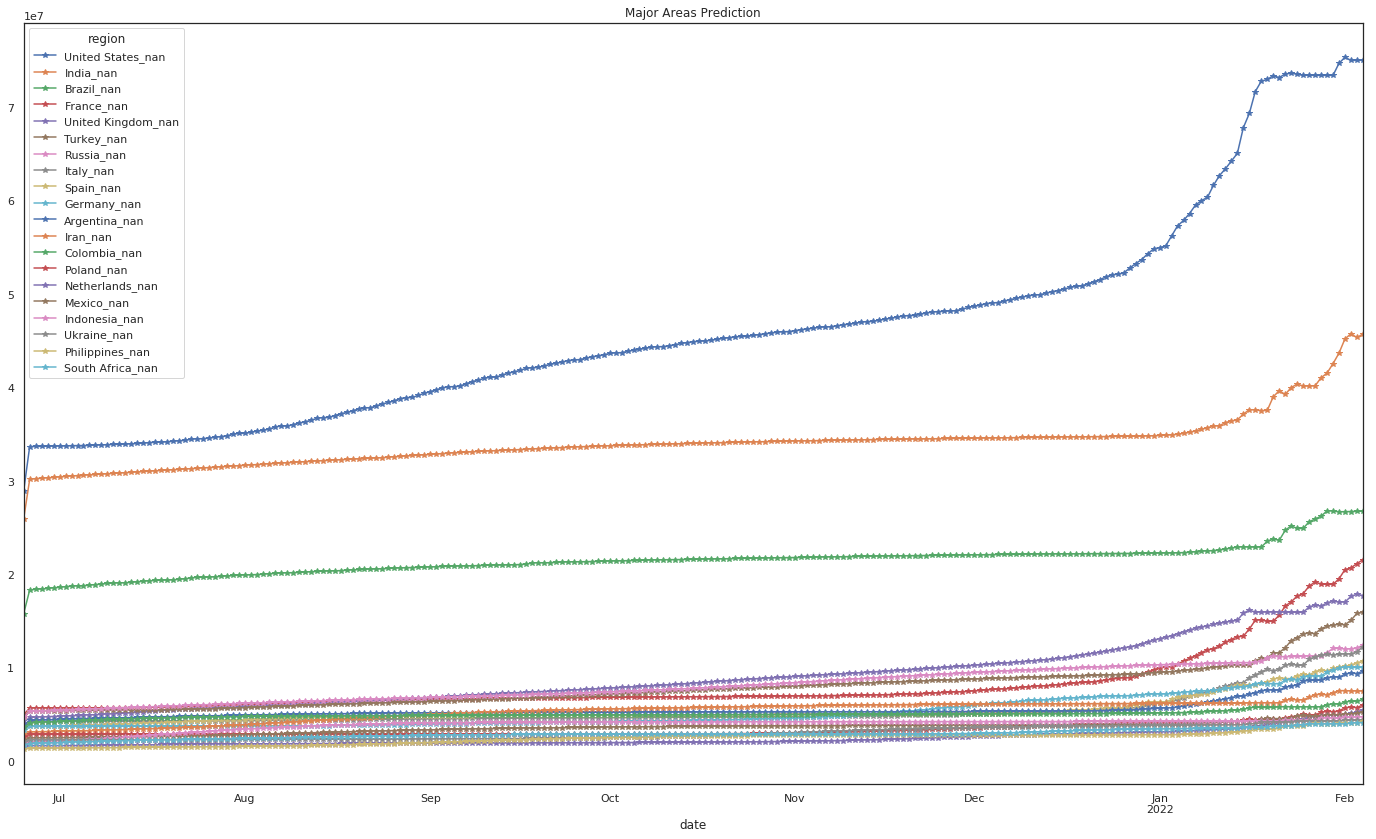

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

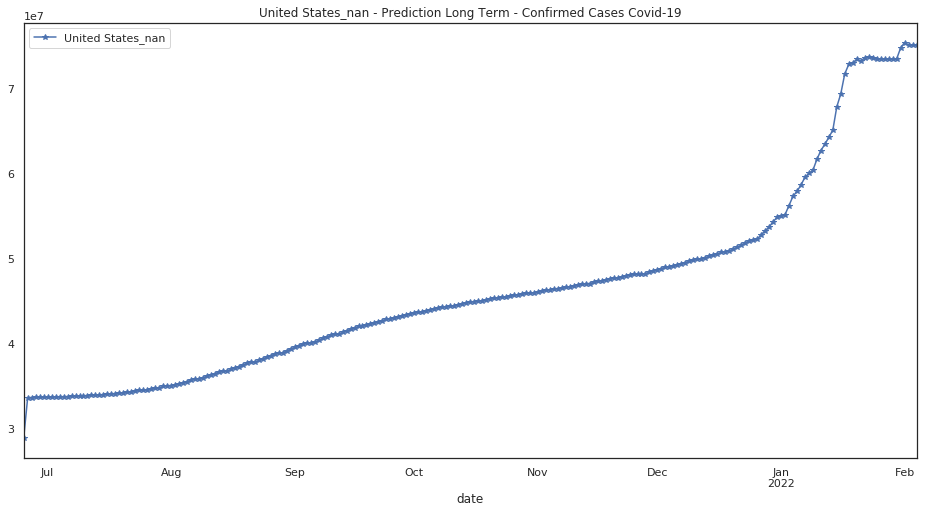

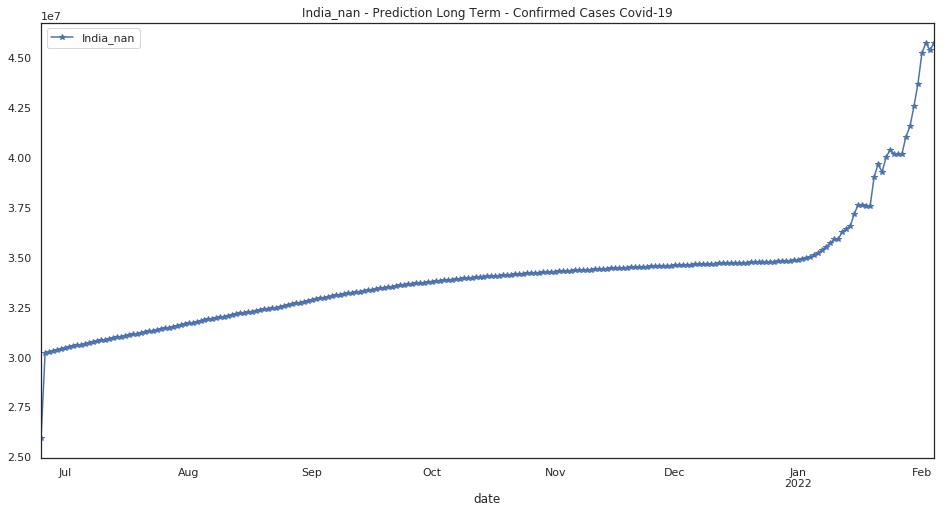

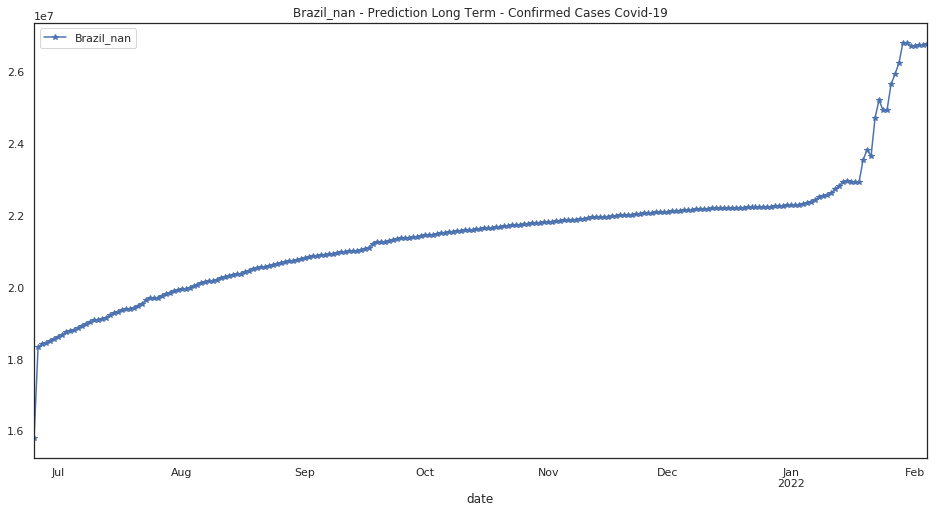

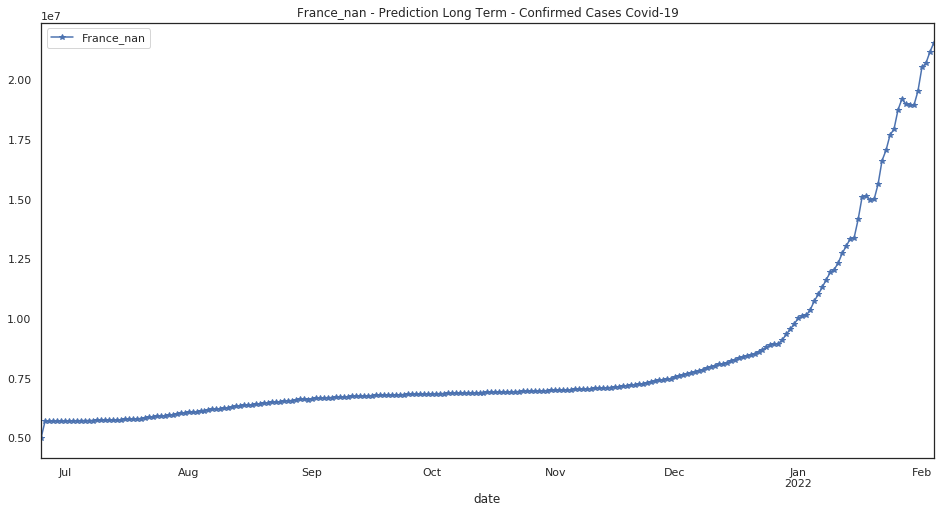

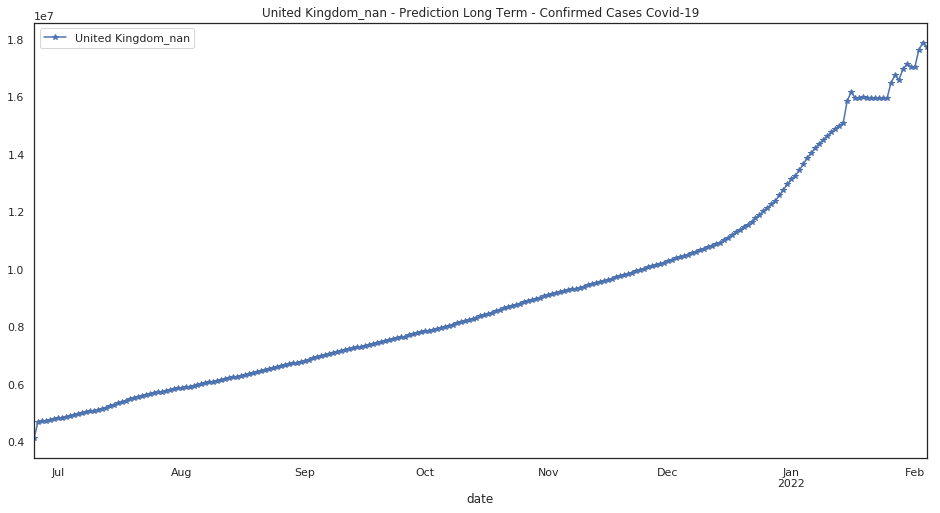

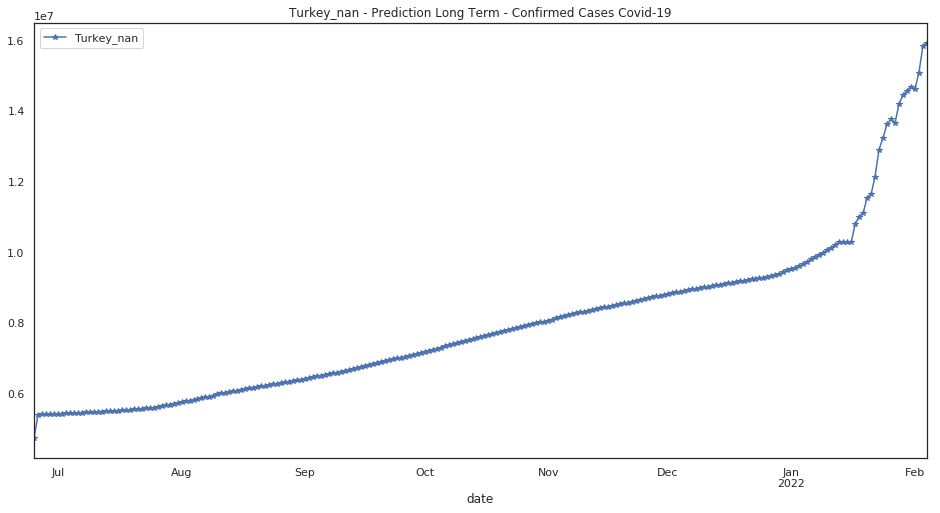

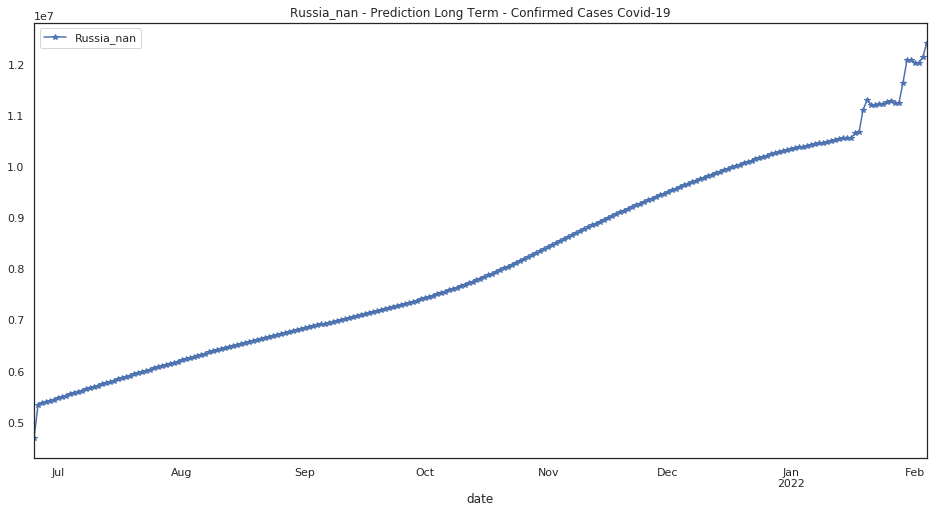

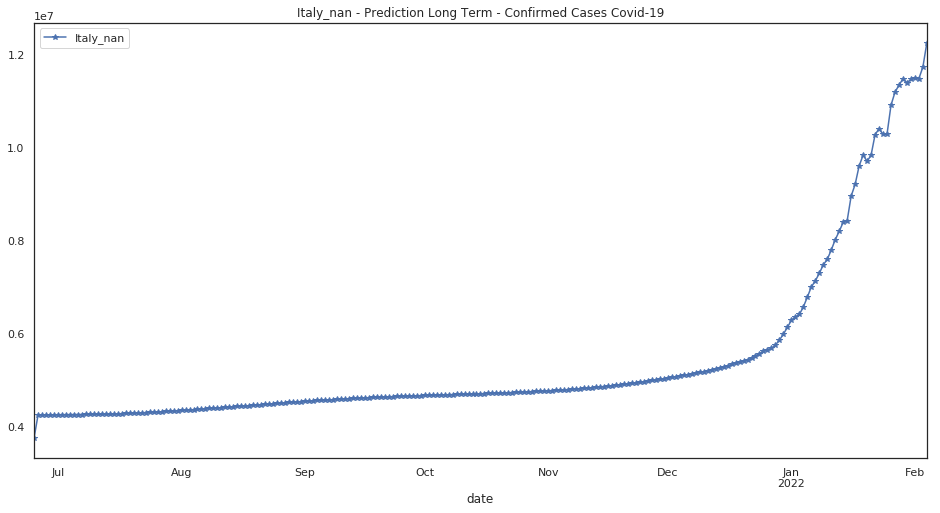

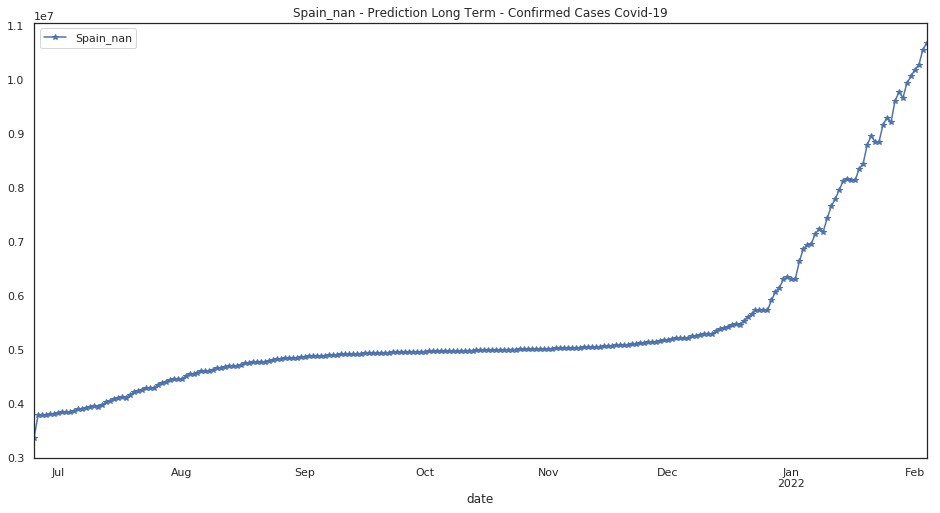

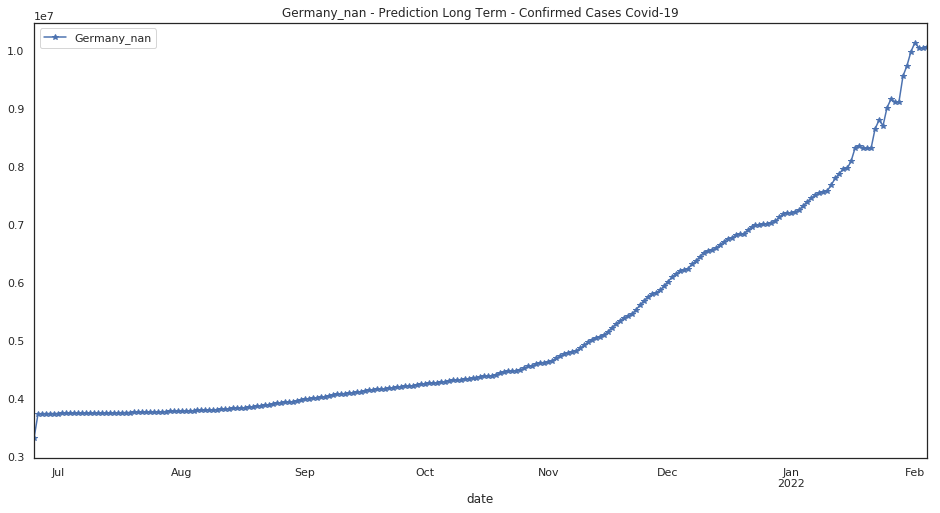

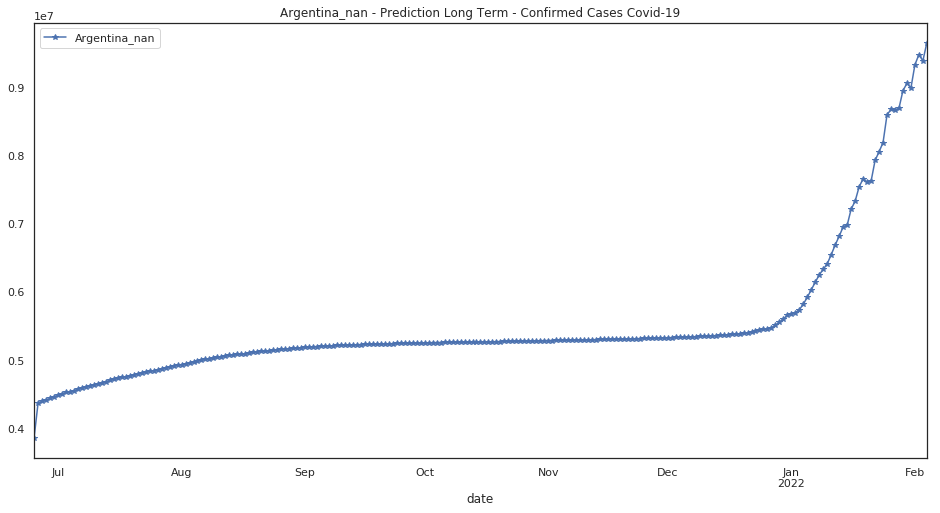

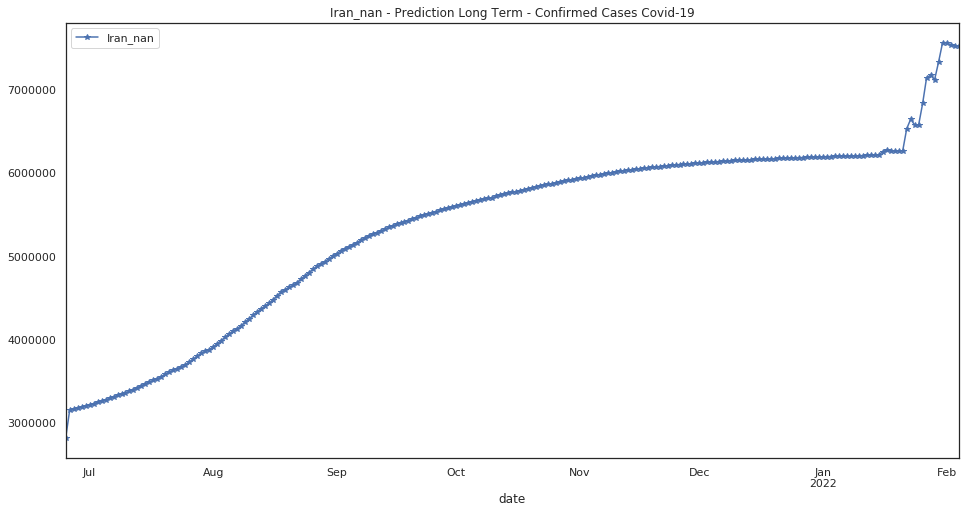

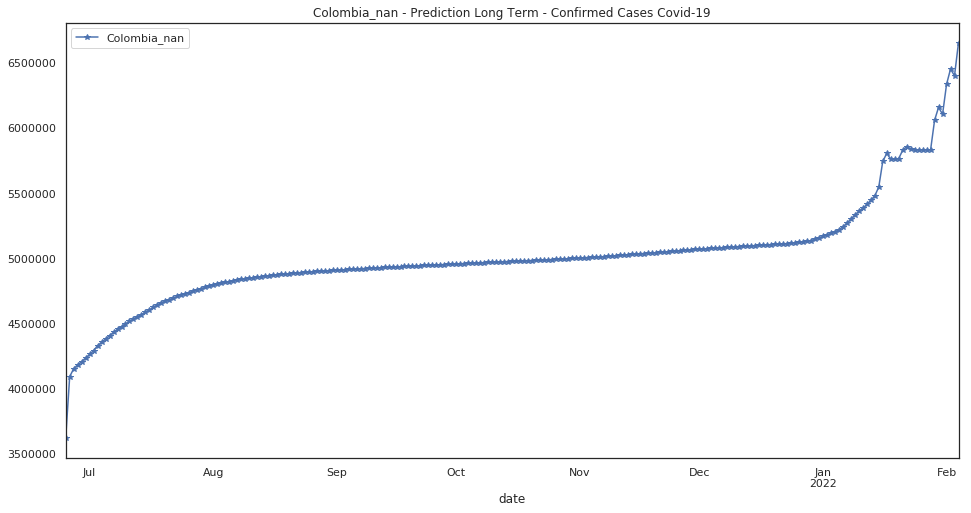

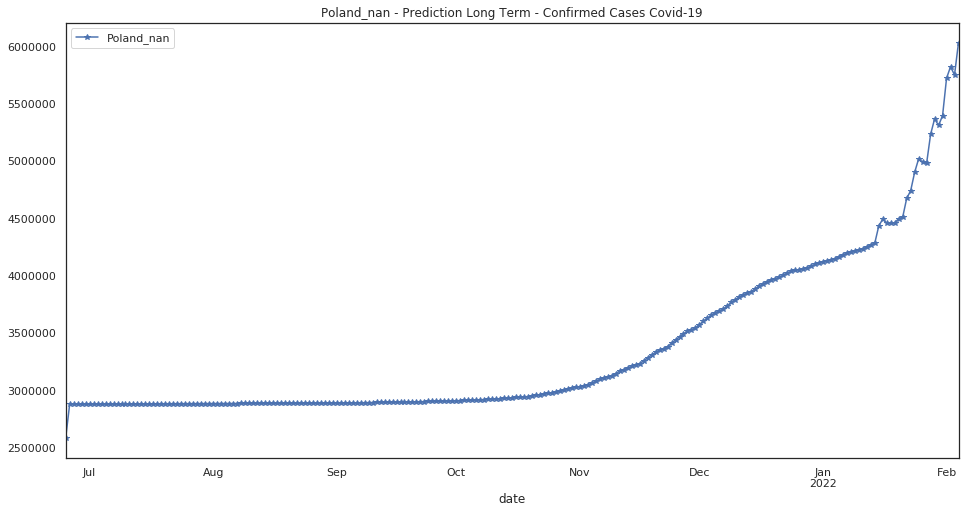

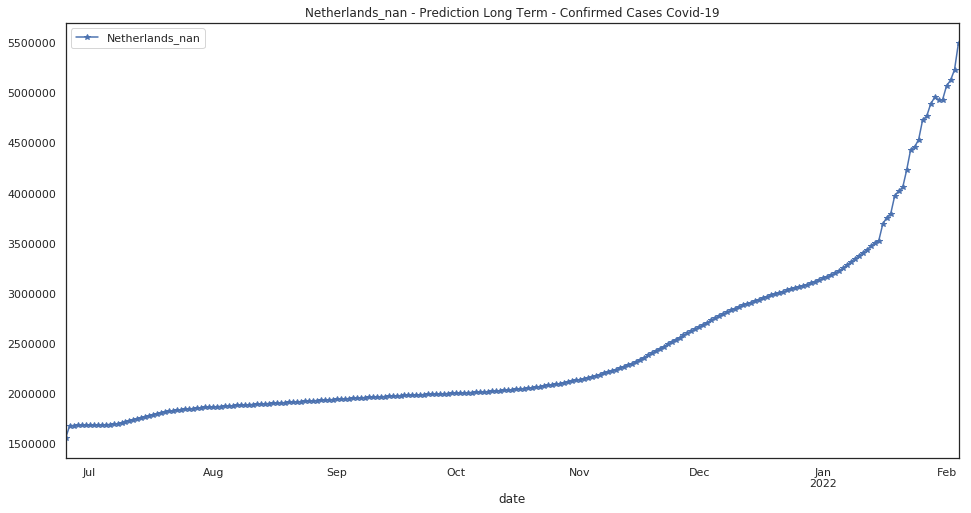

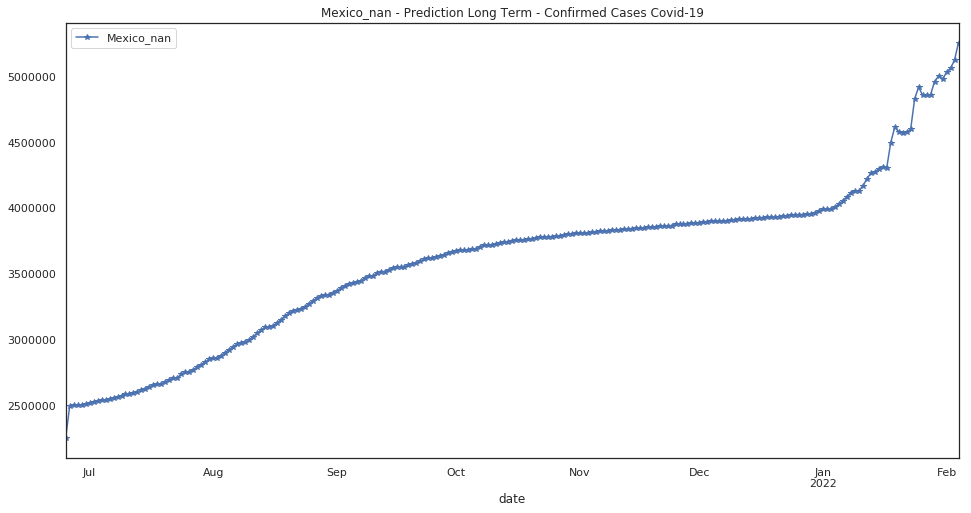

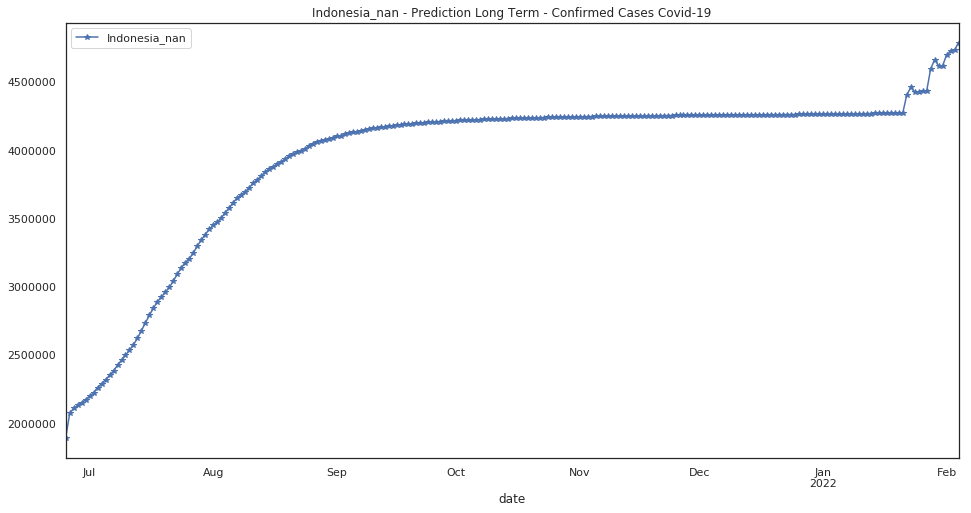

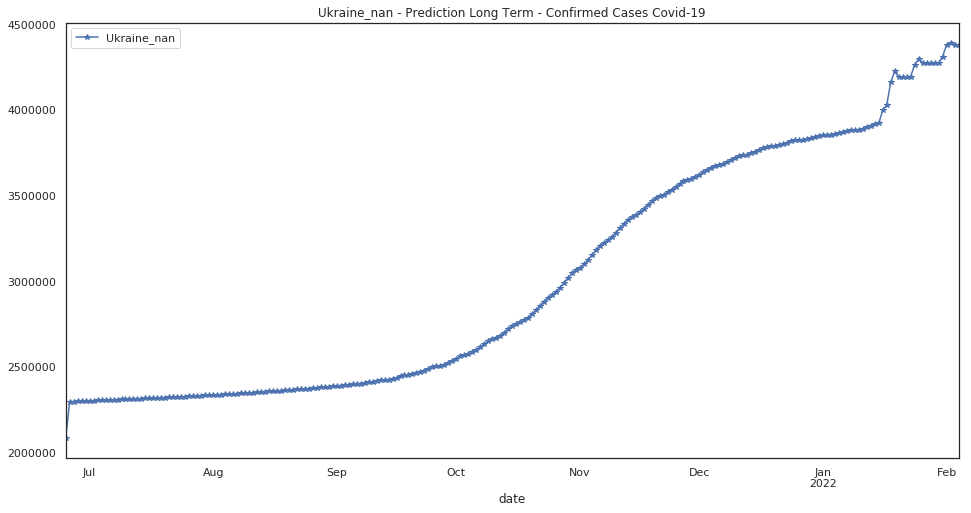

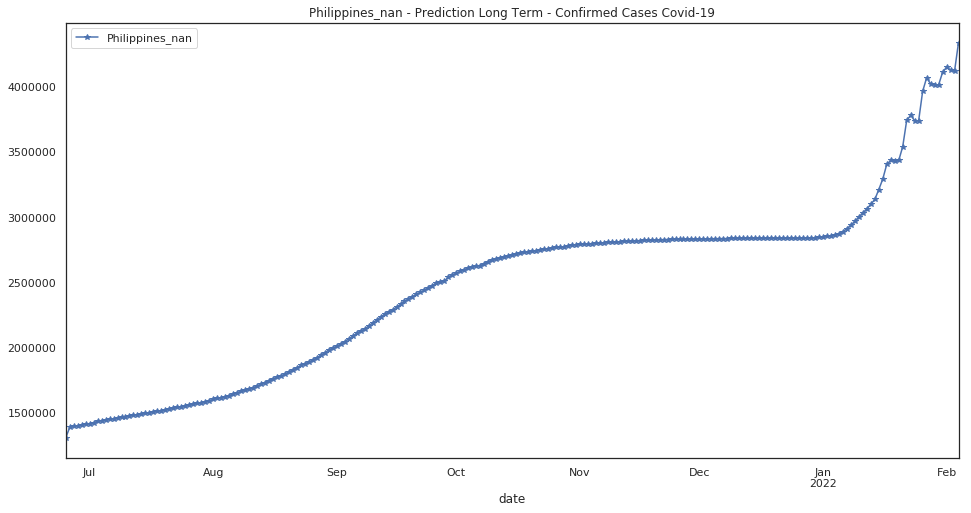

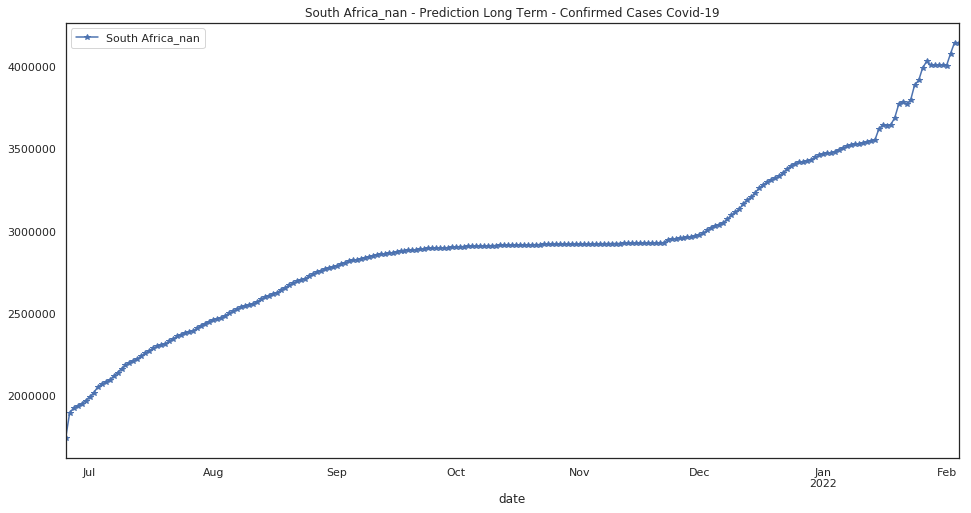

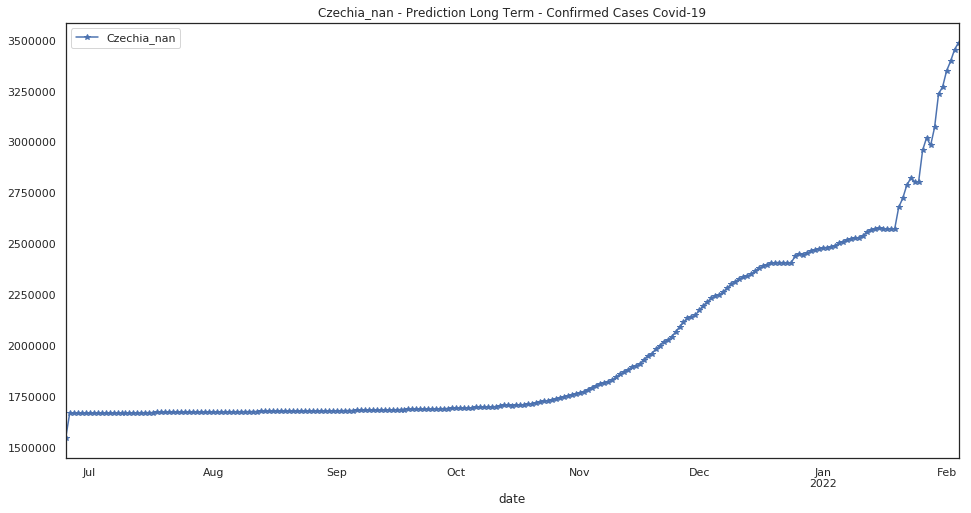

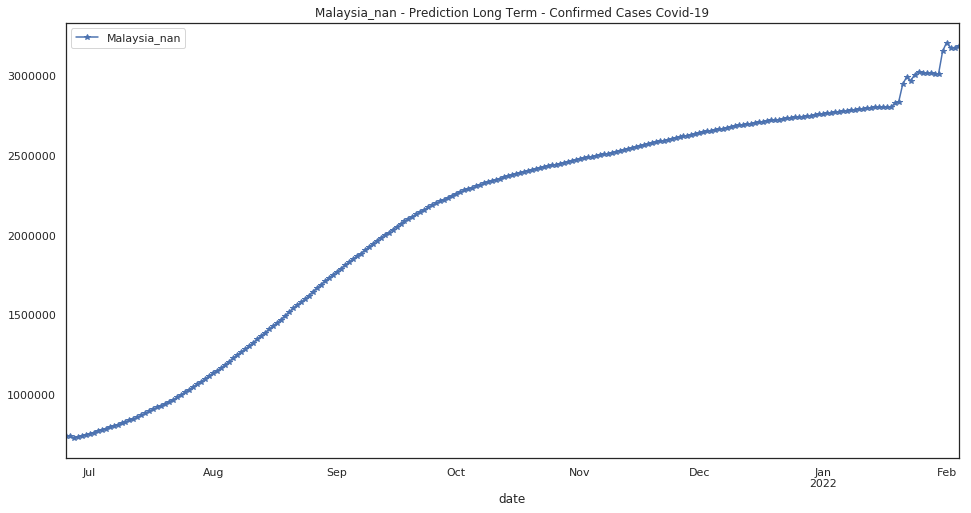

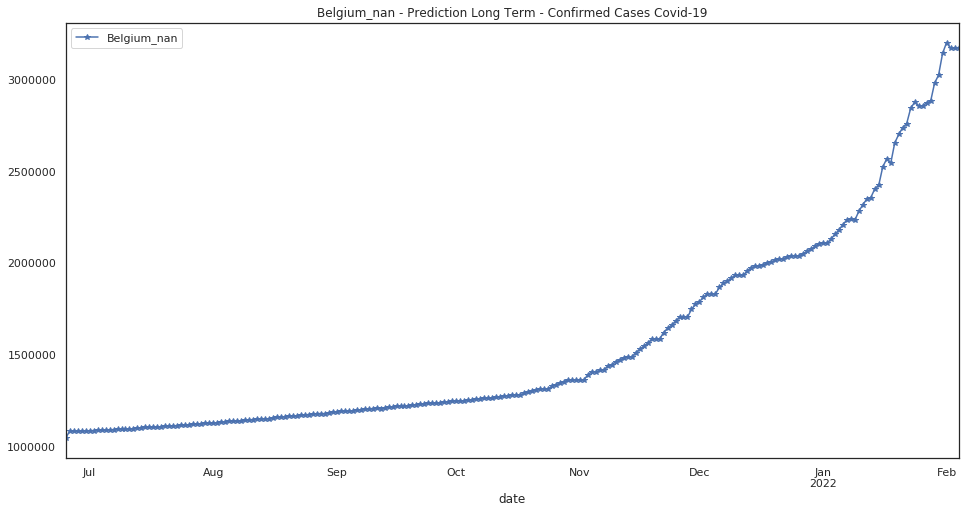

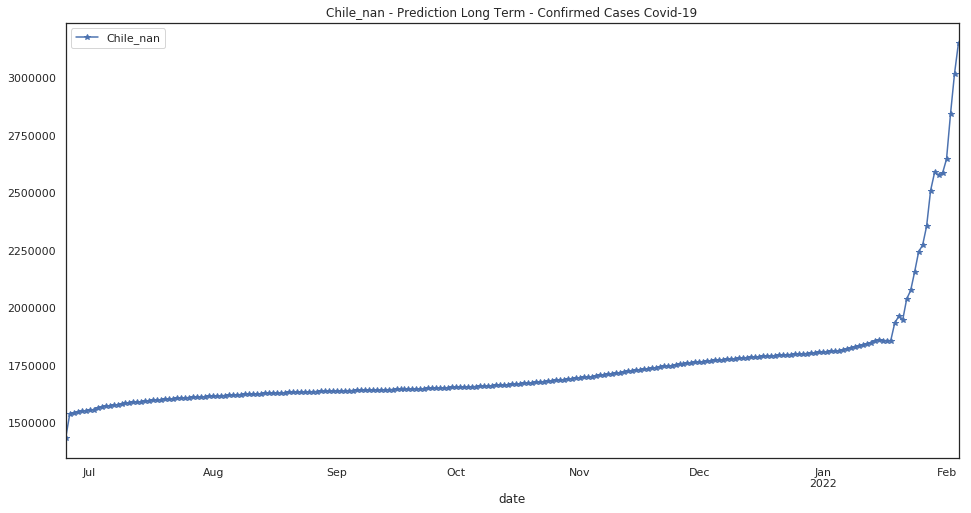

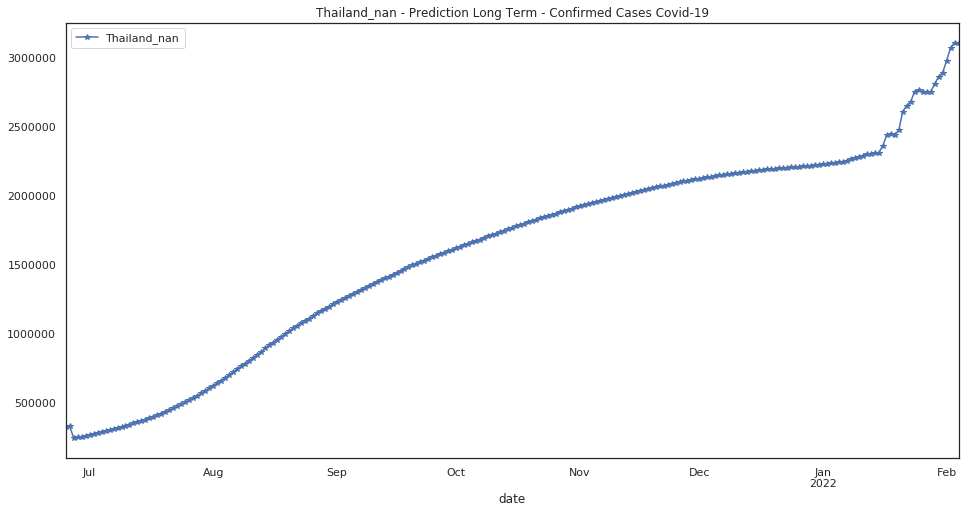

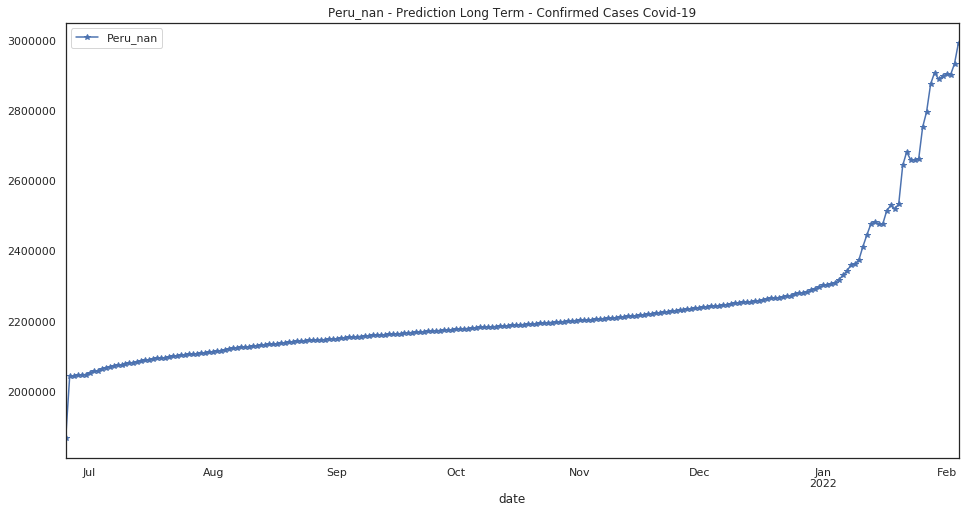

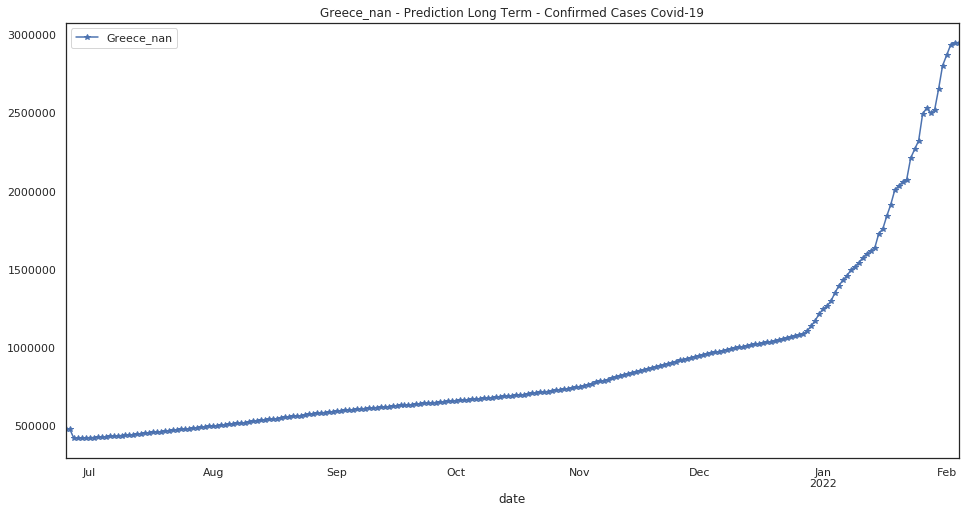

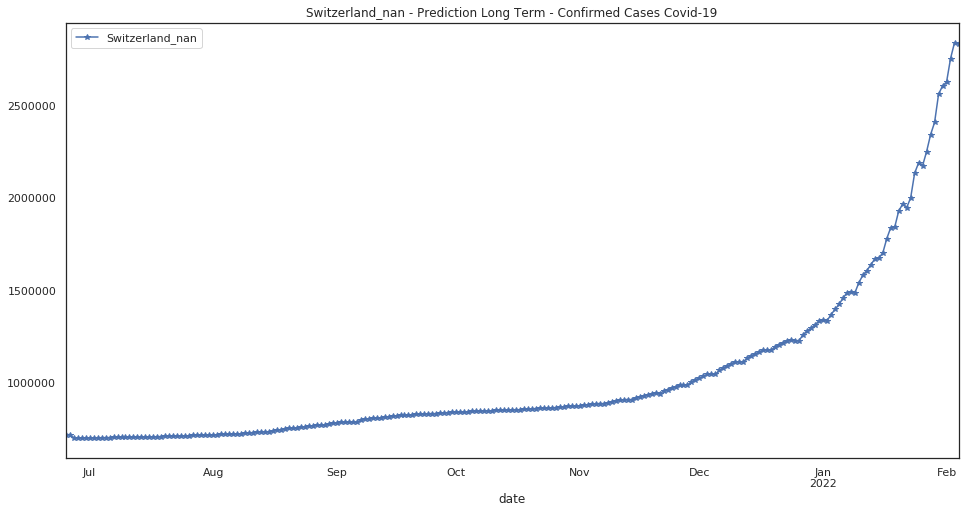

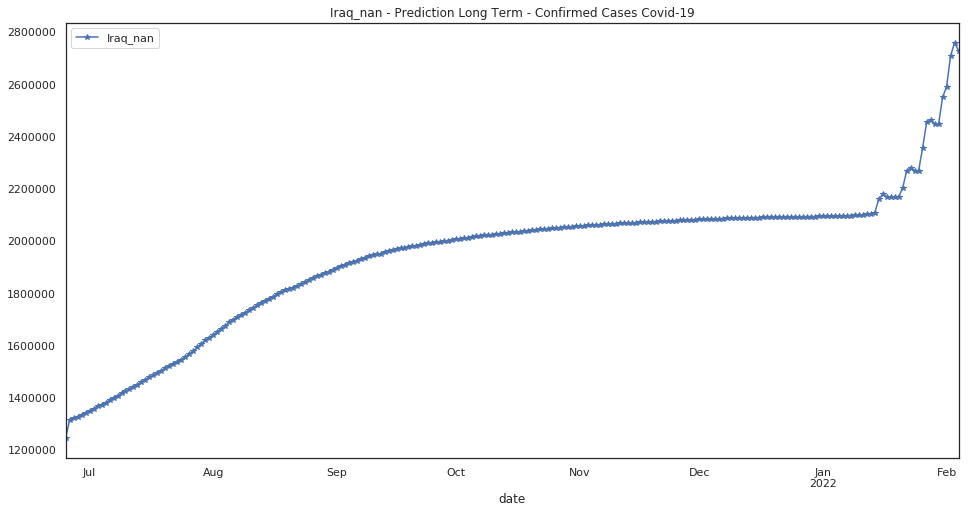

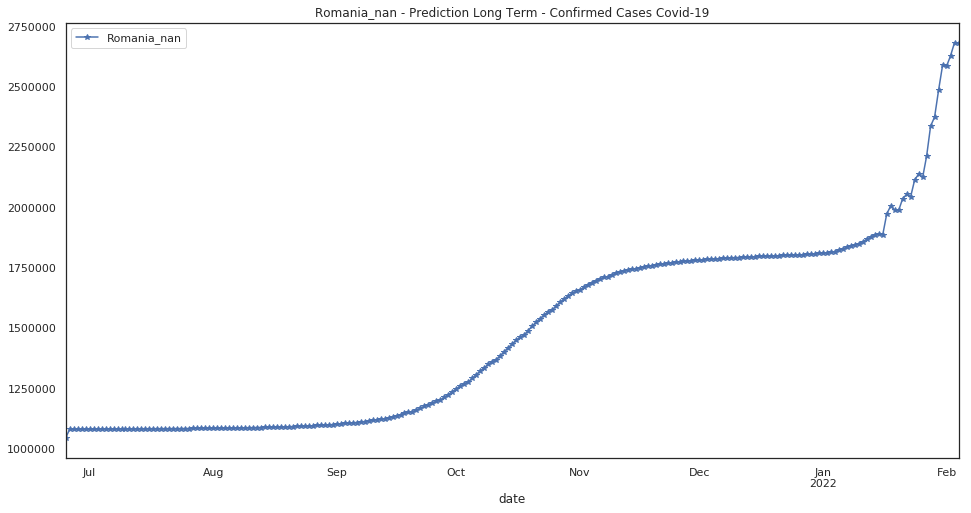

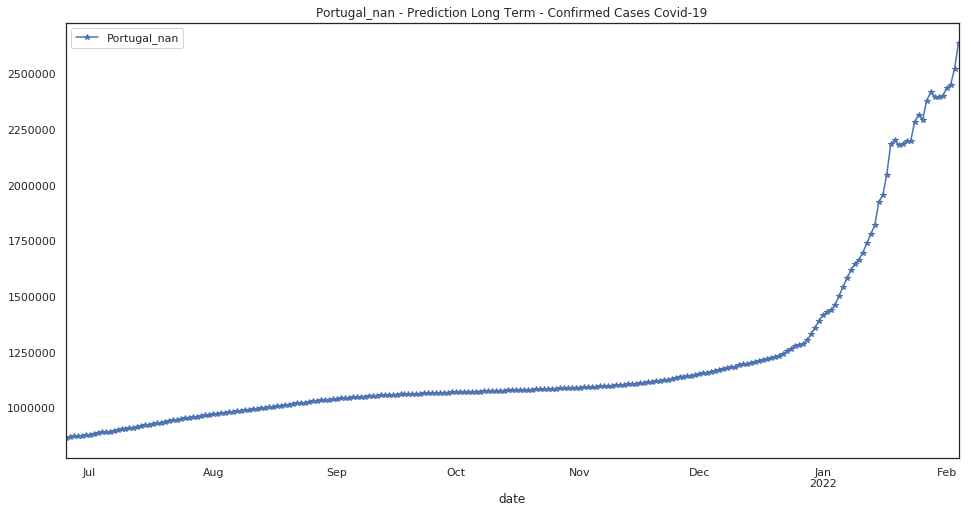

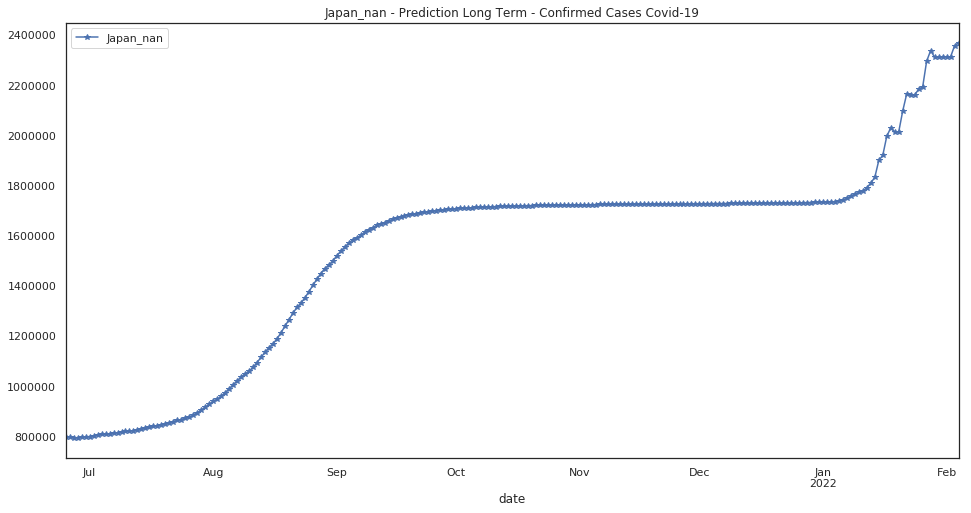

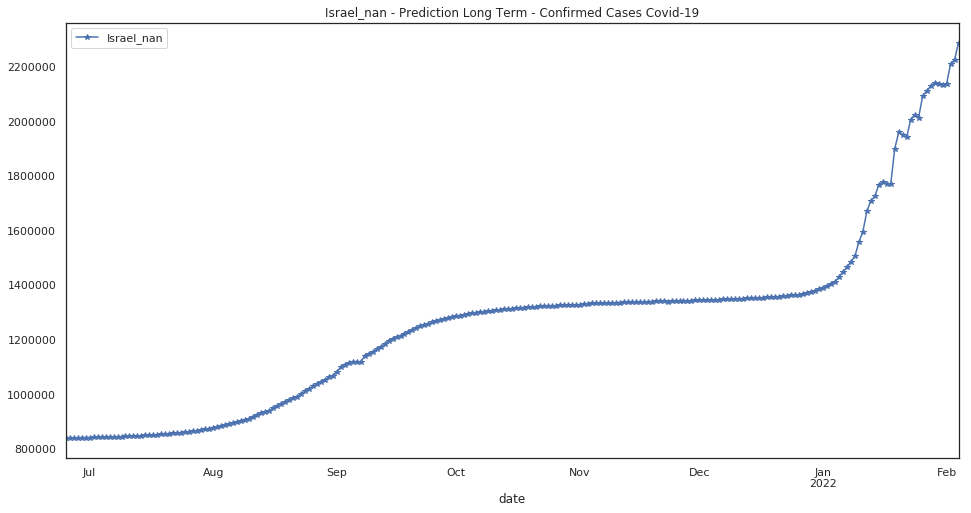

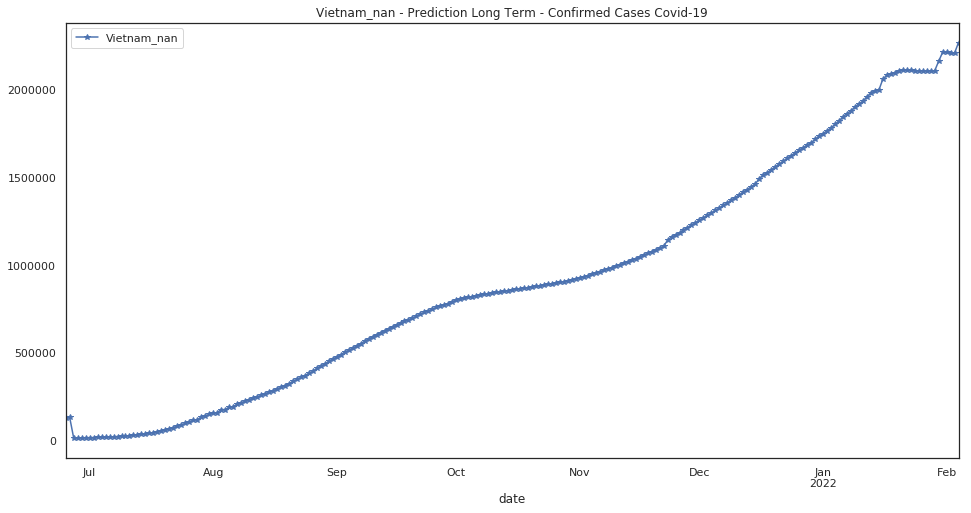

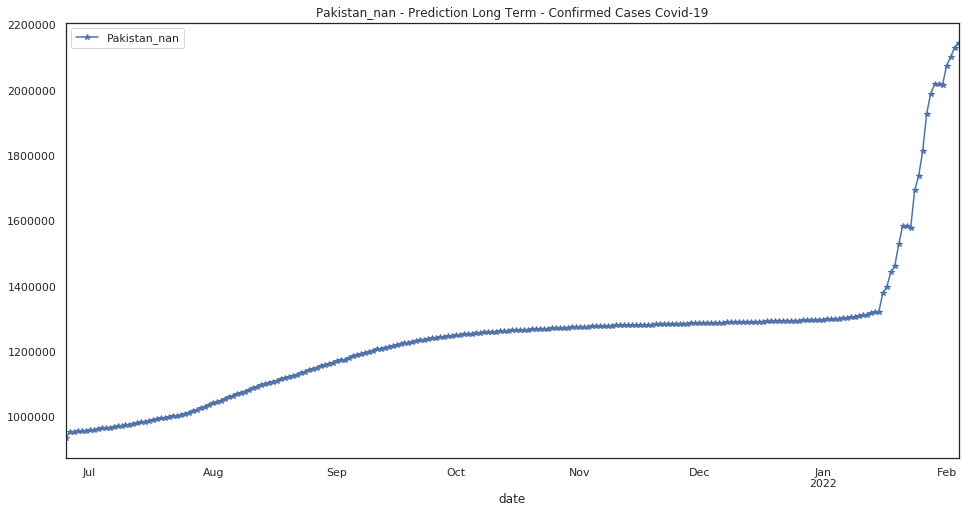

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

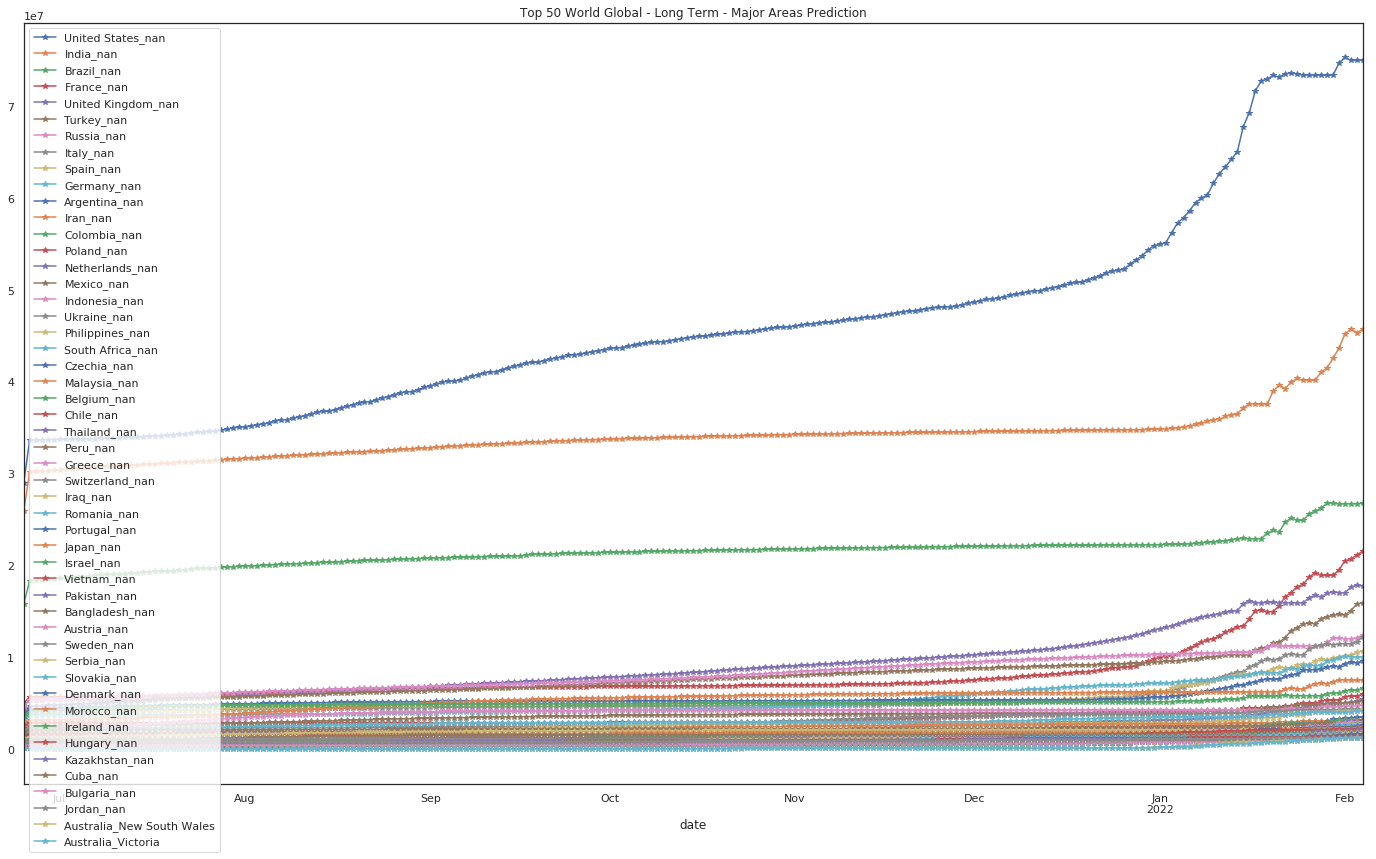

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

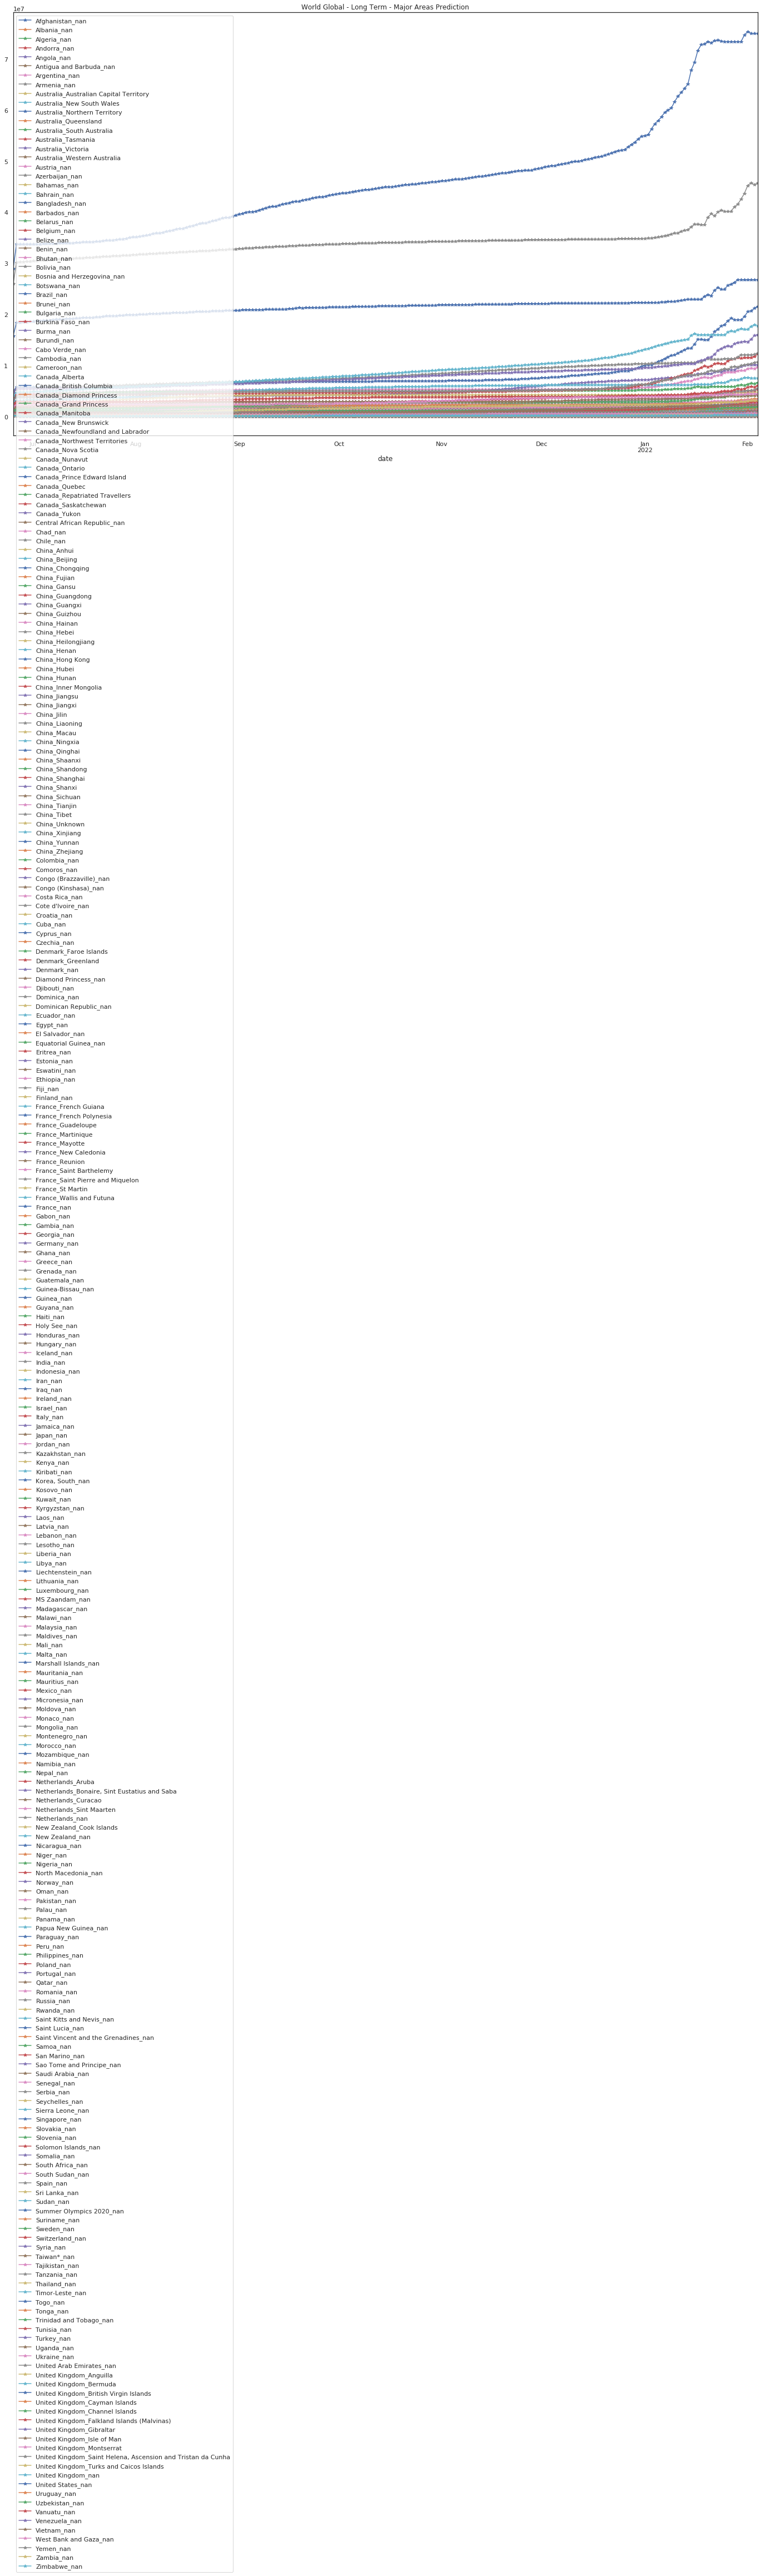

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-08-09         152492.0     135133.0     183935.0      14836.0   
2021-08-10         152669.0     135413.0     184911.0      14836.0   
2021-08-11         152971.0     135594.0     185764.0      14873.0   
2021-08-12         153213.0     135835.0     186640.0      14891.0   
2021-08-13         153424.0     136214.0     187472.0      14908.0   
2021-08-14         153623.0     136561.0     188219.0      14924.0   
2021-08-15         153733.0     136954.0     188870.0      14924.0   
2021-08-16         153878.0     137204.0     189609.0      14924.0   
2021-08-17         153958.0     137761.0     190246.0      14954.0   
2021-08-18         154073.0     138077.0     190955.0      14960.0   
2021-08-19         154110.0     138586.0     191634.0      14976.0   
2021-08-20         154177.0     139103.0     192233.0      14981.0   
2021-08-21         154221.0     139743.0     192791.0      14988.0   
2021-08-22         154226.0     140227.0     193233.0      14988.0   
2021-08-23         154306.0     140734.0     193760.0      14988.0   
2021-08-24         154346.0     141578.0     194243.0      15002.0   
2021-08-25         154406.0     142172.0     194766.0      15003.0   
2021-08-26         154505.0     143046.0     195261.0      15014.0   
2021-08-27         154618.0     143955.0     195778.0      15016.0   
2021-08-28         154662.0     144865.0     196260.0      15025.0   
2021-08-29         154744.0     145678.0     196761.0      15025.0   
2021-08-30         154859.0     146306.0     197186.0      15025.0   
2021-08-31         154889.0     147461.0     197706.0      15032.0   
2021-09-01         154958.0     148113.0     198122.0      15033.0   
2021-09-02         155020.0     149037.0     198538.0      15046.0   
2021-09-03         155079.0     150001.0     198947.0      15052.0   
2021-09-04         155089.0     150945.0     199297.0      15055.0   
2021-09-05         155142.0     151804.0     199653.0      15055.0   
2021-09-06         155237.0     152423.0     199962.0      15055.0   
2021-09-07         155284.0     153363.0     200300.0      15069.0   
...                     ...          ...          ...          ...   
2022-01-06         159969.0     214124.0     222413.0      25289.0   
2022-01-07         160001.0     215327.0     222910.0      25289.0   
2022-01-08         160014.0     215430.0     223323.0      26408.0   
2022-01-09         160086.0     220098.0     223763.0      26408.0   
2022-01-10         160072.0     219990.0     224243.0      26408.0   
2022-01-11         160173.0     223388.0     224773.0      27983.0   
2022-01-12         160186.0     224902.0     225357.0      28542.0   
2022-01-13         160290.0     227135.0     225928.0      28899.0   
2022-01-14         160310.0     229279.0     226539.0      28899.0   
2022-01-15         162604.0     229572.0     226624.0      29888.0   
2022-01-16         161700.0     230272.0     226798.0      29888.0   
2022-01-17         163137.0     230041.0     226783.0      29888.0   
2022-01-18         163136.0     230025.0     233690.0      29888.0   
2022-01-19         165952.0     229911.0     233070.0      31239.0   
2022-01-20         170120.0     229877.0     235113.0      31239.0   
2022-01-21         175386.0     235540.0     235083.0      31239.0   
2022-01-22         177159.0     235604.0     235146.0      32257.0   
2022-01-23         179689.0     236660.0     242728.0      33336.0   
2022-01-24         179730.0     236661.0     244548.0      33336.0   
2022-01-25         185880.0     238113.0     246862.0      33336.0   
2022-01-26         184285.0     245718.0     250888.0      35280.0   
2022-01-27         195734.0     246301.0     250631.0      35280.0   
2022-01-28         194689.0     247805.0     254967.0      35280.0   
2022-01-29         198345.0     254557.0     254670.0      35744.0   
2022-01-30

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                              Antigua and Barbuda_nan  17.060800  -61.796400   
6                                        Argentina_nan -38.416100  -63.616700   
7                                          Armenia_nan  40.069100   45.038200   
8               Australia_Australian Capital Territory -35.473500  149.012400   
9                            Australia_New South Wales -33.868800  151.209300   
10                        Australia_Northern Territory -12.463400  130.845600   
11                                Australia_Queensland -27.469800  153.025100   
12                           Australia_South Australia -34.928500  138.600700   
13                                  Australia_Tasmania -42.882100  147.327200   
14                                  Australia_Victoria -37.813600  144.963100   
15                         Australia_Western Australia -31.950500  115.860500   
16                                         Austria_nan  47.516200   14.550100   
17                                      Azerbaijan_nan  40.143100   47.576900   
18                                         Bahamas_nan  25.025885  -78.035889   
19                                         Bahrain_nan  26.027500   50.550000   
20                                      Bangladesh_nan  23.685000   90.356300   
21                                        Barbados_nan  13.193900  -59.543200   
22                                         Belarus_nan  53.709800   27.953400   
23                                         Belgium_nan  50.833300    4.469936   
24                                          Belize_nan  17.189900  -88.497600   
25                                           Benin_nan   9.307700    2.315800   
26                                          Bhutan_nan  27.514200   90.433600   
27                                         Bolivia_nan -16.290200  -63.588700   
28                          Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                        Botswana_nan -22.328500   24.684900   
..                                                 ...        ...         ...   
256                                           Togo_nan   8.619500    0.824800   
257                                          Tonga_nan -21.179000 -175.198200   
258                            Trinidad and Tobago_nan  10.691800  -61.222500   
259                                        Tunisia_nan  33.886917    9.537499   
260                                         Turkey_nan  38.963700   35.243300   
261                                  United States_nan  40.000000 -100.000000   
262                                         Uganda_nan   1.373333   32.290275   
263                                        Ukraine_nan  48.379400   31.165600   
264                           United Arab Emirates_nan  23.424076   53.847818   
265                            United Kingdom_Anguilla  18.220600  -63.068600   
266                             United Kingdom_Bermuda  32.307800  -64.750500   
267              United Kingdom_British Virgin Islands  18.420700  -64.640000   
268                      United Kingdom_Cayman Islands  19.313300  -81.254600   
269                     United Kingdom_Channel Islands  49.372300   -2.364400   
270         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
271                           United Kingdom_Gibraltar  36.140800   -5.353600   
272                         United Kingdom_Isle of Man  54.236100   -4.548100   
273                          United Kingdom_Montserrat  16.742498  -62.187366  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                     region        Lat        Long  \
0       6              Argentina_nan -38.416100  -63.616700   
1       9  Australia_New South Wales -33.868800  151.209300   
2      16                Austria_nan  47.516200   14.550100   
3      20             Bangladesh_nan  23.685000   90.356300   
4      23                Belgium_nan  50.833300    4.469936   
5      30                 Brazil_nan -14.235000  -51.925300   
6      32               Bulgaria_nan  42.733900   25.485800   
7      59                  Chile_nan -35.675100  -71.543000   
8      94               Colombia_nan   4.570900  -74.297300   
9     100                Croatia_nan  45.100000   15.200000   
10    101                   Cuba_nan  21.521757  -77.781167   
11    103                Czechia_nan  49.817500   15.473000   
12    106                Denmark_nan  56.263900    9.501800   
13    132                 France_nan  46.227600    2.213700   
14    137                Germany_nan  51.165691   10.451526   
15    139                 Greece_nan  39.074200   21.824300   
16    149                Hungary_nan  47.162500   19.503300   
17    151                  India_nan  20.593684   78.962880   
18    152              Indonesia_nan  -0.789300  113.921300   
19    153                   Iran_nan  32.427908   53.688046   
20    154                   Iraq_nan  33.223191   43.679291   
21    155                Ireland_nan  53.142400   -7.692100   
22    156                 Israel_nan  31.046051   34.851612   
23    157                 Israel_nan  31.046051   34.851612   
24    158                  Italy_nan  41.871940   12.567380   
25    160                  Japan_nan  36.204824  138.252924   
26    161                 Jordan_nan  31.240000   36.510000   
27    162             Kazakhstan_nan  48.019600   66.923700   
28    182               Malaysia_nan   4.210484  101.975766   
29    189                 Mexico_nan  23.634500 -102.552800   
30    195                Morocco_nan  31.791700   -7.092600   
31    203            Netherlands_nan  52.132600    5.291300   
32    212               Pakistan_nan  30.375300   69.345100   
33    217                   Peru_nan  -9.190000  -75.015200   
34    218            Philippines_nan  12.879721  121.774017   
35    219                 Poland_nan  51.919400   19.145100   
36    220               Portugal_nan  39.399900   -8.224500   
37    222                Romania_nan  45.943200   24.966800   
38    223                 Russia_nan  61.524010  105.318756   
39    233                 Serbia_nan  44.016500   21.005900   
40    237               Slovakia_nan  48.669000   19.699000   
41    241           South Africa_nan -30.559500   22.937500   
42    243                  Spain_nan  40.463667   -3.749220   
43    248                 Sweden_nan  60.128161   18.643501   
44    249            Switzerland_nan  46.818200    8.227500   
45    254               Thailand_nan  15.870032  100.992541   
46    260                 Turkey_nan  38.963700   35.243300   
47    261          United States_nan  40.000000 -100.000000   
48    263                Ukraine_nan  48.379400   31.165600   
49    276         United Kingdom_nan  55.378100   -3.436000   
50    281                Vietnam_nan  14.058324  108.277199   

    2021-06-25 00:00:00  2021-06-26 00:00:00  2021-06-27 00:00:00  \
0             3863360.0            4374587.0            4399313.0   
1              124089.0             124116.0               5756.0   
2              675532.0             675683.0             650192.0   
3              871350.0             878804.0             883138.0   
4             1045671.0            1082476.0            1082476.0   
5            15809807.0           18332493.0           18419737.0   
6              479936.0             479960.0             421515.0   
7             1435097.0            1537471.0            1542642.0   
8             3622134.0            4092746.0            4153229.0   
9              426900.0             4

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()